# Chromosome ideograms

In [1]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

%matplotlib inline
# %config InlineBackend.figure_format = 'retina'
%config InlineBackend.figure_format = 'svg'

import geneinfo as gi
#gi.email('your@email.com')

ModuleNotFoundError: No module named 'geneinfo'

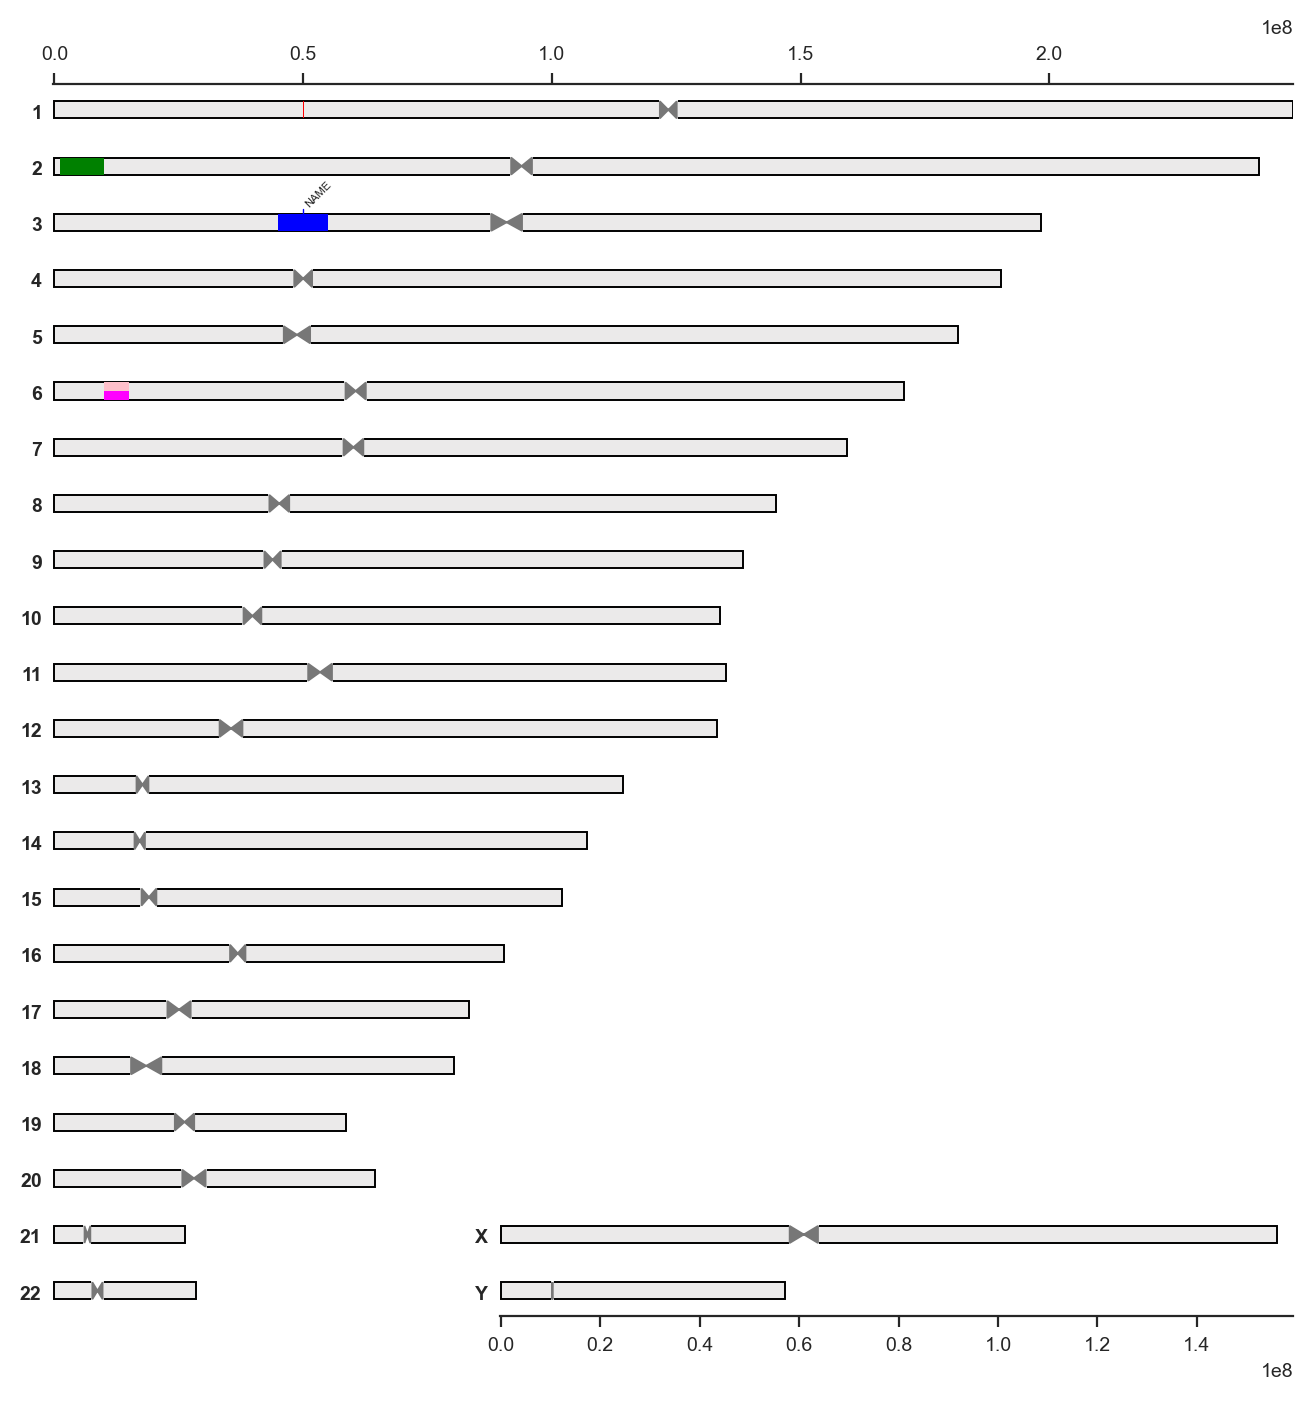

In [2]:
annotation = [
    ('chr1', 50000000, 50001000),                          # segment color defaults to red
    ('chr2', 10000000, 1000000, 'green'),                  # with segment color
    ('chr3', 45000000, 55000000, 'blue', 'NAME'),          # with name label
    ('chr6', 10000000, 15000000, 'magenta', None, 0, 0.5), # with base and height
    ('chr6', 10000000, 15000000, 'pink', None, 0.5, 0.5),  # with base and height
]

gi.chrom_ideogram(annotation, figsize=(8, 8)) ;

To make sure segments are visible on the plot, the default minimal size of plotteed segments are 200000. This can be changed like this (notice how the chr1 segment is no longer visible):

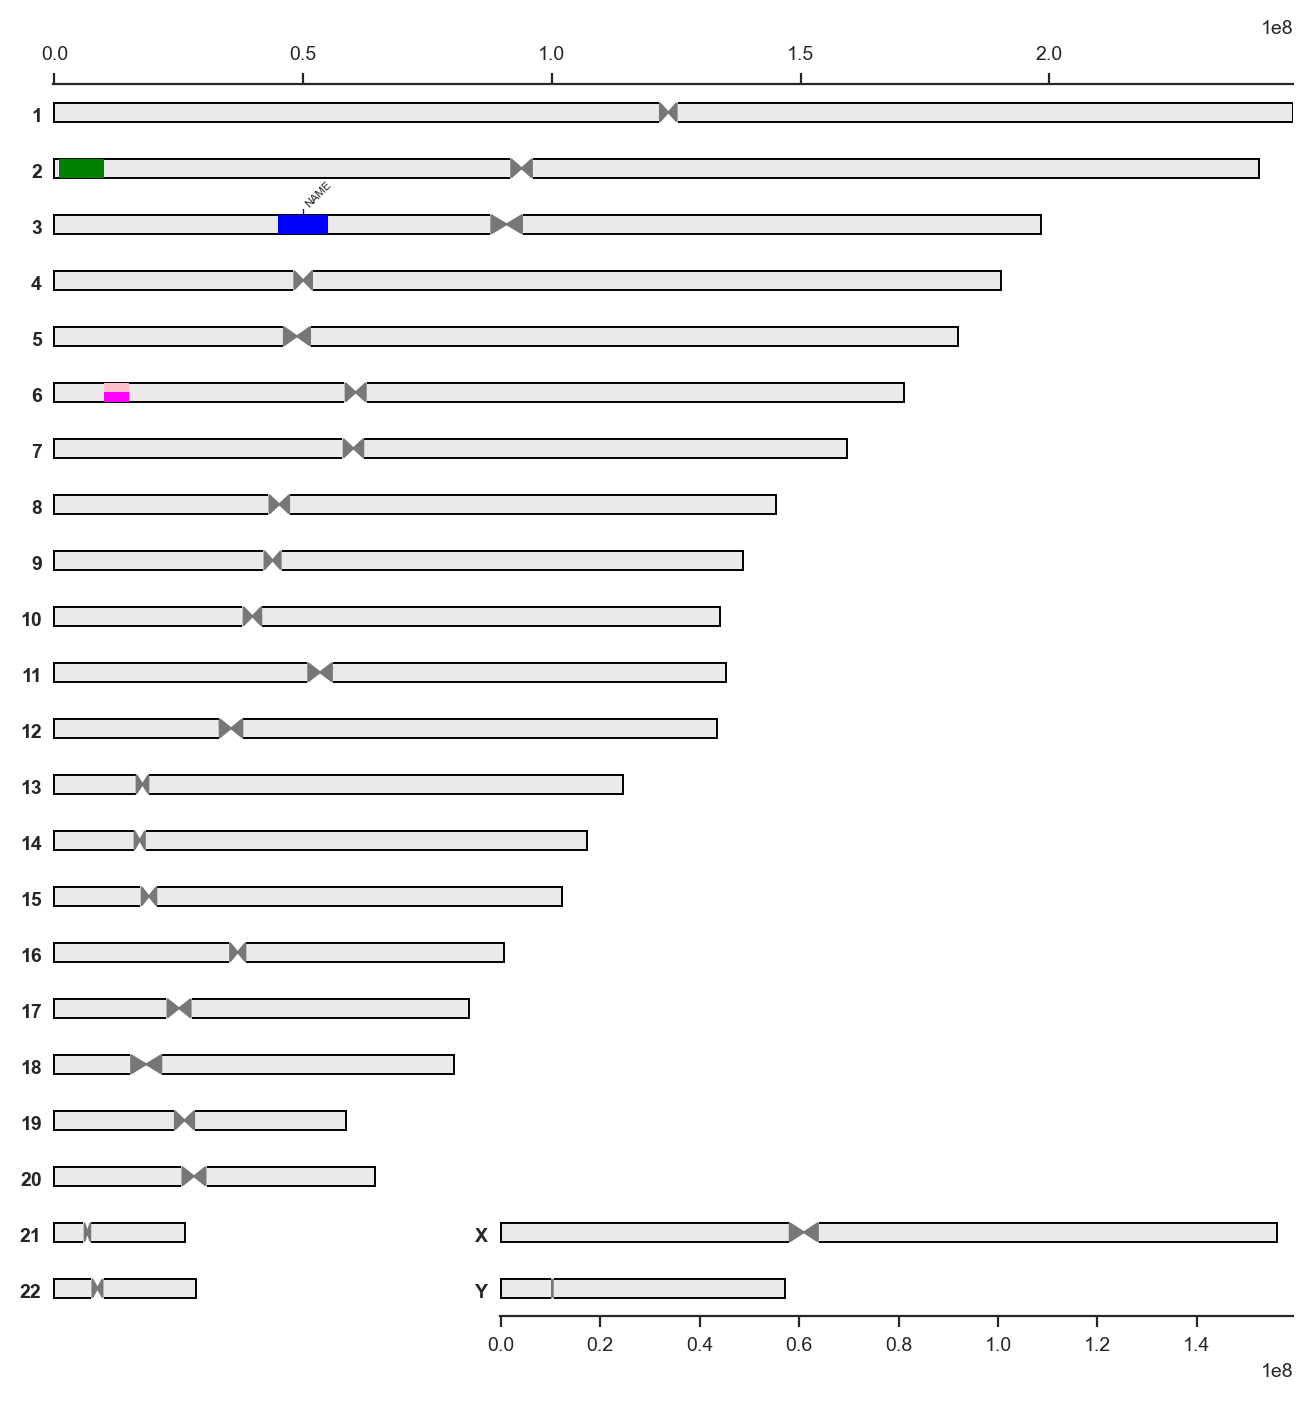

In [3]:
gi.chrom_ideogram(annotation, figsize=(8, 8), min_visible_width=1, hspace=0)

Other assembly, figure dimentions:

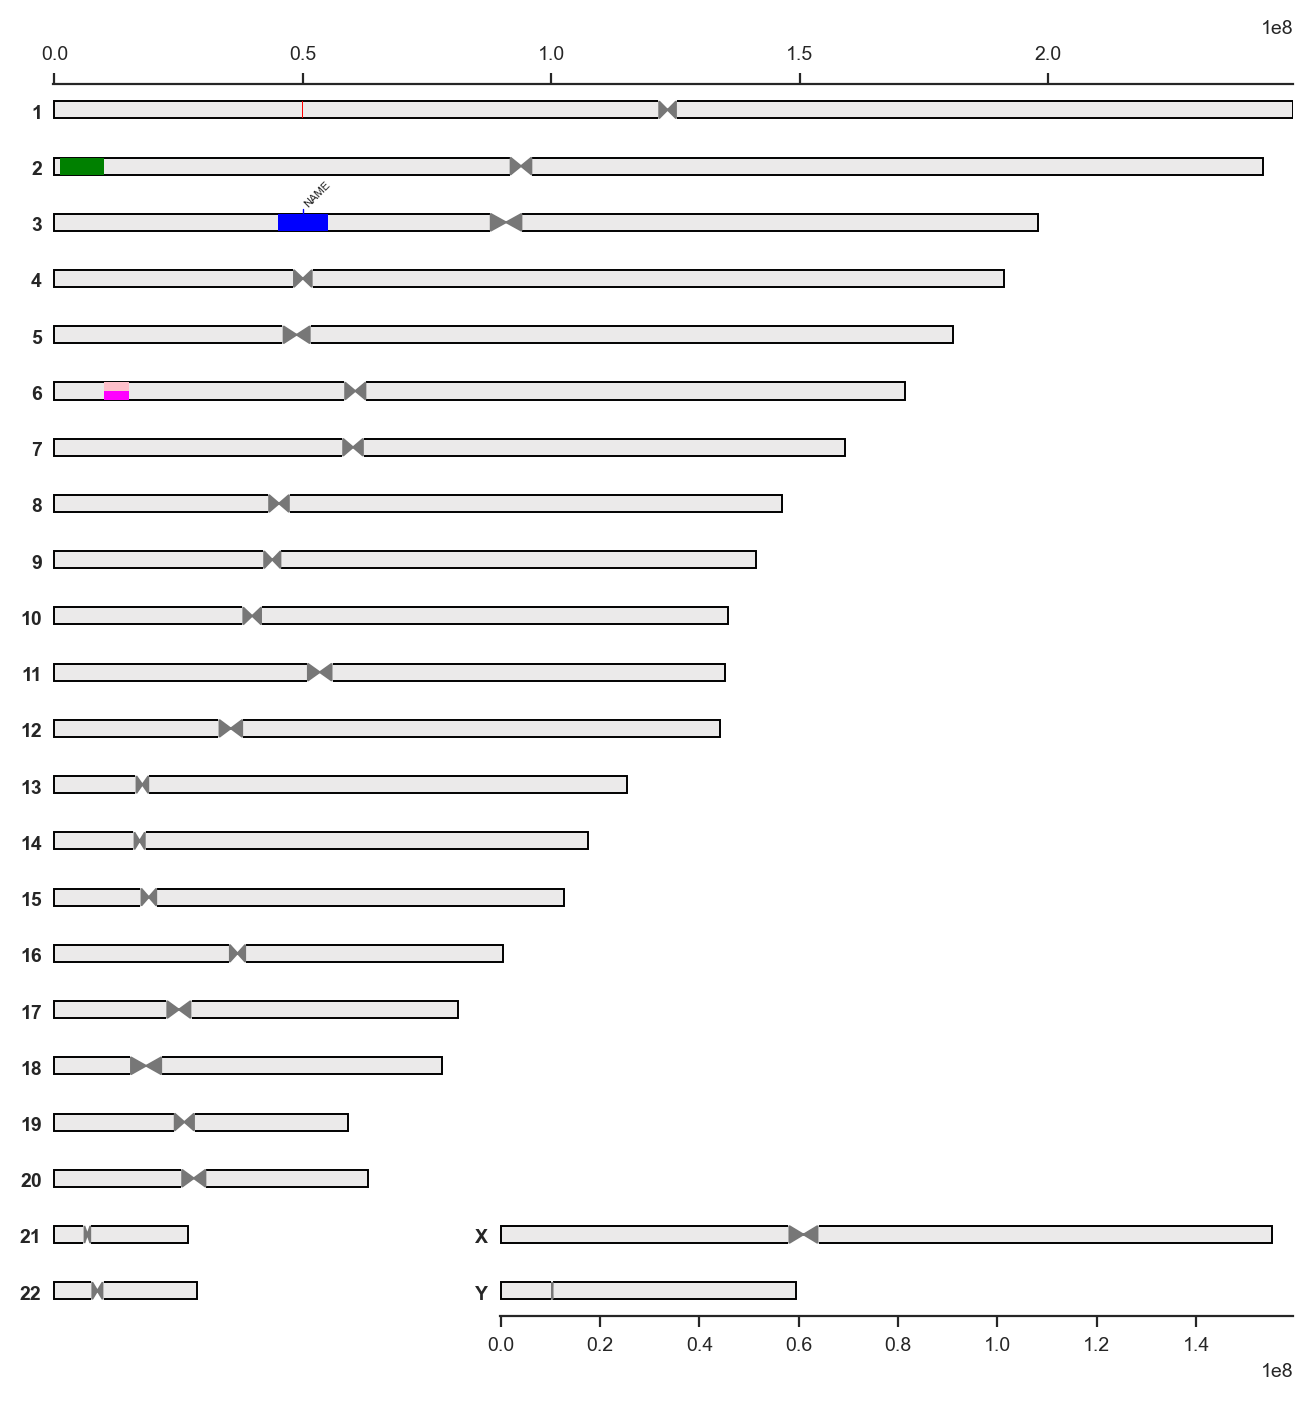

In [4]:
gi.chrom_ideogram(annotation, assembly='hg19', figsize=(8, 8))

**You can add position markers along a chromosome like this to better see the location of some segments:**

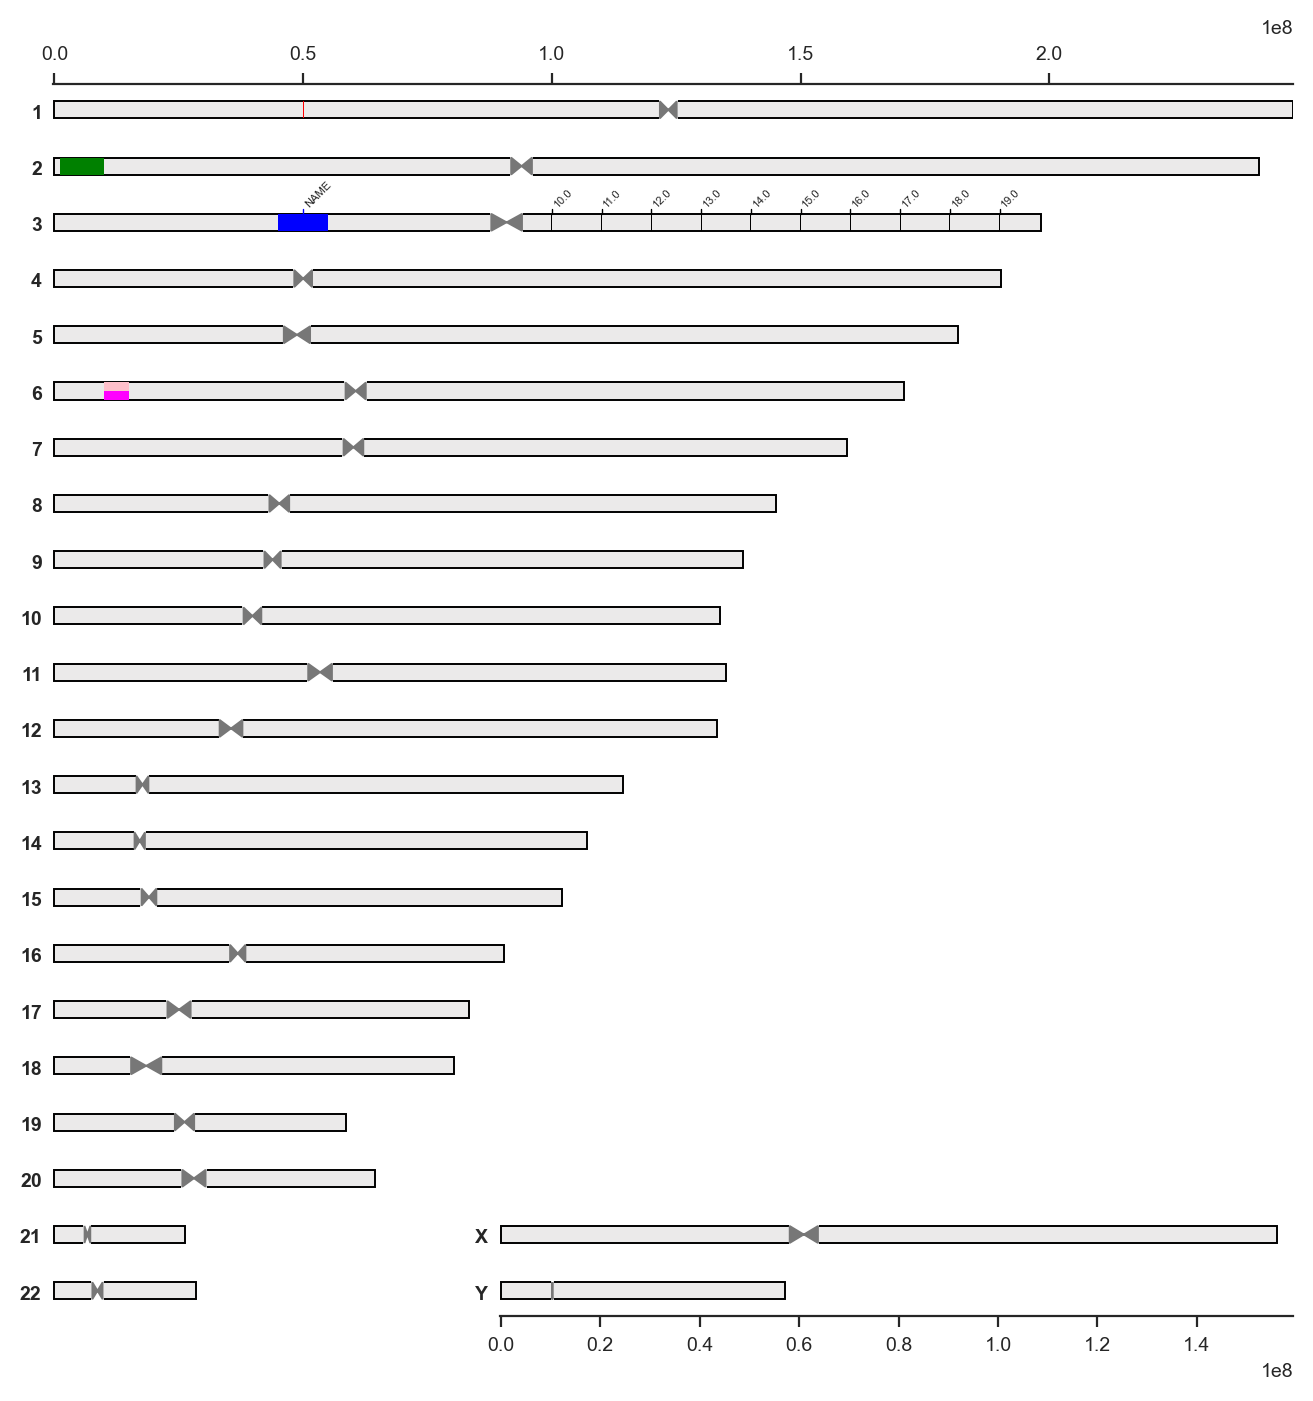

In [5]:
chrom = 'chr3'
start = 100000000
end = 200000000
width = 10000000
annotation2 = annotation + [(chrom, x[0], x[1], 'black', str(x[2]/width)) for x in zip(
    range(start, end, width), 
    range(start+1, end, width), 
    range(start, end, width)
)]
gi.chrom_ideogram(annotation2, figsize=(8, 8))

In [6]:
lists = gi.GoogleSheet()

In [7]:
import importlib
import geneinfo
importlib.reload(geneinfo)

coords = gi.gene_coord(lists.get('xi_escape'), assembly='GRCh38')
annotation = [(c, s, e, 'red', g) for g, (c, s, e, _) in coords.items()]

In [8]:
coords = gi.gene_coord(['ATRX', 'MAGT1'], assembly='GRCh38')
annotation = [(c, s, e, 'red', g) for g, (c, s, e, _) in coords.items()]

In [9]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

class Polygon:
    def __init__(self, points):
        self.points = points

    def get_points(self):
        return self.points

    def nudge_y(self, nudge):
        for point in self.points:
            point.y += nudge

def is_polygons_intersecting(a, b):
    for x in range(2):
        polygon = a if x == 0 else b

        for i1 in range(len(polygon.get_points())):
            i2 = (i1 + 1) % len(polygon.get_points())
            p1 = polygon.get_points()[i1]
            p2 = polygon.get_points()[i2]

            normal = Point(p2.y - p1.y, p1.x - p2.x)

            min_a = float('inf')
            max_a = float('-inf')

            for p in a.get_points():
                projected = normal.x * p.x + normal.y * p.y
                min_a = min(min_a, projected)
                max_a = max(max_a, projected)

            min_b = float('inf')
            max_b = float('-inf')

            for p in b.get_points():
                projected = normal.x * p.x + normal.y * p.y
                min_b = min(min_b, projected)
                max_b = max(max_b, projected)

            if max_a < min_b or max_b < min_a:
                return False

    return True

a = list(zip([0, 0, 2, 2], [0, 2, 2, 0]))
b = list(zip([1, 1, 3, 3], [1, 3, 3, 1]))

is_polygons_intersecting(
    Polygon([Point(*tup) for tup in a]),
    Polygon([Point(*tup) for tup in b])
)

True

In [115]:
import time
import warnings
from itertools import chain
# import gc

import numpy as np
import pandas as pd

from statsmodels.nonparametric.smoothers_lowess import lowess


# # Make inline plots vector graphics instead of raster graphics
# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('pdf', 'svg')

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from math import isclose, floor, log10

def horizon(row, i, cut):
    """
    Compute the values for the three 
    positive and negative intervals.
    """
    val = getattr(row, i)

    if np.isnan(val):
        for i in range(8):
            yield 0
        # for nan color
        yield cut
    else:
        if val < 0:
            for i in range(4):
                yield 0

        val = abs(val)
        for i in range(3):
            yield min(cut, val)
            val = max(0, val-cut)
        yield int(not isclose(val, 0, abs_tol=1e-8)) * cut

        if val >= 0:
            for i in range(4):
                yield 0

        # for nan color
        yield 0
    
def horizonplot(df, y=None, ax=None,
                cut=None, # float, takes precedence over quantile_span
                quantile_span = None,
                x='start',
                beginzero=True, 
                offset=0,
                height=None,
                colors = ['#CCE2DF', '#59A9A8', '#374E9B', 'midnightblue',
                          '#F2DE9A', '#DA8630', '#972428', 'darkred',
                          '#D3D3D3']):
                # colours = ['#314E9F', '#36AAA8', '#D7E2D4'] + ['midnightblue'] + \
                #           ['#F5DE90', '#F5DE90', '#A51023'] + ['darkred'] + ['whitesmoke']):
                # colors = sns.color_palette("Blues", 3) + ['midnightblue'] + \
                #           sns.color_palette("Reds", 3) + ['darkred'] + ['lightgrey']):




    
    """
    Horizon bar plot made allowing multiple chromosomes and multiple samples.
    """

    # set cut if not set
    if cut is None:
        cut = np.max([np.max(df[y]), np.max(-df[y])]) / 3
    elif quantile_span:
        cut=max(np.abs(np.nanquantile(df[col], quantile_span[0])), 
                np.abs(np.nanquantile(df[col], quantile_span[1]))) / 3,

    # make the data frame to plot
    row_iter = df.itertuples()
    col_iterators = zip(*(horizon(row, y, cut) for row in row_iter))
    col_names = ['yp1', 'yp2', 'yp3', 'yp4', 
                 'yn1', 'yn2', 'yn3', 'yn4', 'nan']

    df2 = (df[[y, x]]
           .assign(**dict(zip(col_names, col_iterators)))
          )
    df2 = pd.DataFrame(dict((col, list(chain.from_iterable(zip(df2[col].values, df2[col].values)))) for col in df2))

    # make the plot
    with sns.axes_style("ticks"):

        # ingore UserWarning from seaborn that tight_layout is not applied
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            
            # first y tick
            ytic1 = round(cut/3, -int(floor(log10(abs(cut/3)))))

            scale = 1
            if height is not None:
                ymax = max(df2[col_name].max() for col_name in col_names)
                ymin = max(df2[col_name].min() for col_name in col_names)
                scale = height/(ymax-ymin)

            for col_name, color in zip(col_names, colors):
                plt.setp(fig.texts, text="") # hack to make y facet labels align...
                ax.fill_between(
                    df2[x], 
                    df2[col_name]*scale+offset, 
                    y2=offset,
                    color=color,
                    linewidth=0,
                    capstyle='butt')

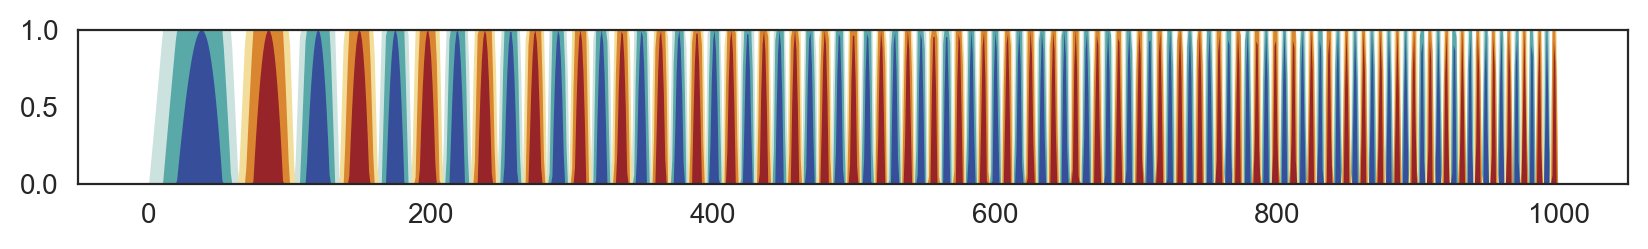

In [33]:
n = 1000

fig, ax = plt.subplots(1, 1, figsize=(10, 1))
plt.ylim(0, 1)
df = pd.DataFrame({'chrom': ['chr1']*n,
                'start': list(range(1*n)), 
                 'pi': list(np.sin(np.linspace(-np.pi, 10*np.pi, 1*n)))                   
                  })
sample = n
Fs = 248956422
# f = 50
f = np.linspace(5, 50, sample)
x = np.linspace(0, Fs, sample)
y = np.sin(2* np.pi * f * x / Fs)
df['pi'] = y

height = 1

horizonplot(df, y='pi', x='start', offset=0, height=1, ax=ax)
#ax.set_axis_off()

In [20]:
# from matplotlib import patches

# fig, ax = plt.subplots(1, 1)
# ax.set_xlim(0, 5)
# ax.set_ylim(0, 5)

# offset = 1
# scale = 3

# xy = np.array([[0, 0], [1, 1], [2, 1], [3, 1], [4, 0]]) 
# xy[:, 1] = xy[:, 1] * scale + offset
# poly = patches.Polygon(xy, closed=False, fc='blue', ec='none')
# ax.add_patch(poly)    
# # xy = np.array([[1, 0], [2, 1], [3, 0], [3, 0]])
# xy[:, 1] = xy[:, 1] * scale + offset
# poly = patches.Polygon(xy, closed=False, fc='red', ec='none')
# ax.add_patch(poly)    


In [22]:
def add_lowess(x, y, ax=None, color=None, is_sorted=True, frac=0.005, it=0, lowess_kwargs={}, **kwargs):
    "Add a lowess curve to the plot"
    if ax is None:
        ax = plt.gca() 
    filtered = lowess(y, x, is_sorted=is_sorted, frac=frac, it=it, **lowess_kwargs)
    ax.plot(filtered[:,0], filtered[:,1], **kwargs)

def add_band(x_low, x_high, y_low=None, y_high=None, ax=None, color='gray', linewidth=0, alpha=0.5, zorder=0, **kwargs):
    "Plot a gray block on x interval"
    if ax is None:
        ax = plt.gca()
    if y_low is None:
        y_low, _ = ax.get_ylim()
    if y_high is None:
        _, y_high = ax.get_ylim()
    g = ax.add_patch(Rectangle((x_low, y_low), x_high-x_low, y_high-y_low, 
                 facecolor=color,
                 linewidth=linewidth,
                 alpha=alpha,
                 zorder=zorder,
                 **kwargs))

def stairs(df, start='start', end='end', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pd.concat([df1, df2]).sort_values([start, end])

In [146]:
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.artist import Artist
import matplotlib.gridspec as gridspec
from operator import sub
import random
import numpy as np
from collections import defaultdict
from itertools import cycle
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import seaborn as sns
from matplotlib.axes import Axes


import matplotlib.pyplot as plt

from matplotlib.transforms import (Bbox, TransformedBbox,
                                   blended_transform_factory)
from mpl_toolkits.axes_grid1.inset_locator import (BboxConnector,
                                                   BboxConnectorPatch,
                                                   BboxPatch)



import time
import warnings
from itertools import chain
# import gc

import numpy as np
import pandas as pd

from statsmodels.nonparametric.smoothers_lowess import lowess


# # Make inline plots vector graphics instead of raster graphics
# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('pdf', 'svg')

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from math import isclose, floor, log10




%matplotlib inline
%config InlineBackend.figure_format = 'retina'

class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

class Polygon:
    def __init__(self, points):
        self.points = points

    def get_points(self):
        return self.points

    def nudge_y(self, nudge):
        for point in self.points:
            point.y += nudge
            
class GenomeIdeogram(object):

    d = {'axes.linewidth': 0.8, 'grid.linewidth': 0.64, 'lines.linewidth': 0.96, 
         'lines.markersize': 3.84, 'patch.linewidth': 0.64, 'xtick.major.width': 0.8,
         'ytick.major.width': 0.8, 'xtick.minor.width': 0.64, 'ytick.minor.width': 0.64,
         'xtick.major.size': 3.84, 'ytick.major.size': 3.84, 'xtick.minor.size': 2.56, 
         'ytick.minor.size': 2.56, 'font.size': 7.68, 'axes.labelsize': 7.68,
         'axes.titlesize': 7.68, 'xtick.labelsize': 7.04, 'ytick.labelsize': 7.04, 
         'legend.fontsize': 7.04, 'legend.title_fontsize': 7.68}
    
    chrom_lengths = {'hg19': {'chr1': 249250621, 'chr2': 243199373, 'chr3': 198022430, 'chr4': 191154276, 
                              'chr5': 180915260, 'chr6': 171115067, 'chr7': 159138663, 'chr8': 146364022, 
                              'chr9': 141213431, 'chr10': 135534747, 'chr11': 135006516, 'chr12': 133851895,
                              'chr13': 115169878, 'chr14': 107349540, 'chr15': 102531392, 'chr16': 90354753, 
                              'chr17': 81195210, 'chr18': 78077248, 'chr19': 59128983, 'chr20': 63025520, 
                              'chr21': 48129895, 'chr22': 51304566, 'chrX': 155270560, 'chrY': 59373566},
                     'hg38': {'chr1': 248956422, 'chr2': 242193529, 'chr3': 198295559, 'chr4': 190214555, 
                              'chr5': 181538259, 'chr6': 170805979, 'chr7': 159345973, 'chr8': 145138636, 
                              'chr9': 138394717, 'chr10': 133797422, 'chr11': 135086622, 'chr12': 133275309, 
                              'chr13': 114364328, 'chr14': 107043718, 'chr15': 101991189, 'chr16': 90338345, 
                              'chr17': 83257441, 'chr18': 80373285, 'chr19': 58617616, 'chr20': 64444167, 
                              'chr21': 46709983, 'chr22': 50818468, 'chrX': 156040895, 'chrY': 57227415}}    

    # TODO: make the centromeres fit each assembly!
    centromeres = {
        'chr1':    (121700000, 125100000),
        'chr10':   (38000000, 41600000),
        'chr11':   (51000000, 55800000),
        'chr12':   (33200000, 37800000),
        'chr13':   (16500000, 18900000),
        'chr14':   (16100000, 18200000),
        'chr15':   (17500000, 20500000),
        'chr16':   (35300000, 38400000),
        'chr17':   (22700000, 27400000),
        'chr18':   (15400000, 21500000),
        'chr19':   (24200000, 28100000),
        'chr2':    (91800000, 96000000),
        'chr20':   (25700000, 30400000),
        'chr21':   (10900000, 13000000),
        'chr22':   (13700000, 17400000),
        'chr3':    (87800000, 94000000),
        'chr4':    (48200000, 51800000),
        'chr5':    (46100000, 51400000),
        'chr6':    (58500000, 62600000),
        'chr7':    (58100000, 62100000),
        'chr8':    (43200000, 47200000),
        'chr9':    (42200000, 45500000),
        'chrX':    (58100000, 63800000),
        'chrY':    (10300000, 10400000)}                     

    
    def __init__(self, axes_height_inches=1, axes_width_inches=12, hspace=0, ylim=(0, 1), 
                 rel_font_height=0.05, assembly:str='hg38', min_stick_height=0.3):

        self.ideogram_base = None
        self.ideogram_height = None
        self.min_stick_height = min_stick_height
        self.legend_handles = []
        self.zoom_axes = []
        
        self.end_padding = 300000
        self.chr_names = [f'chr{x}' for x in list(range(1, 23))+['X', 'Y']]
        self.chr_sizes = [self.chrom_lengths[assembly][chrom] for chrom in self.chr_names]
        self.max_chrom_size = max(self.chr_sizes)
        nr_rows = len(self.chr_names) - 1
        self.aspect = axes_height_inches / axes_width_inches
        axes_width = self.max_chrom_size + 2 * self.end_padding
        axes_height = self.aspect * axes_width
        fig_height_inches = axes_height_inches * (nr_rows-1) + hspace * (nr_rows-1)
        fig_width_inches = axes_width_inches #fig_height_inches / (nr_rows-1) / aspect 
        figsize = (fig_width_inches, fig_height_inches)
        point_size = 1/72
        self.ylim = ylim
        self.font_size = rel_font_height * axes_height_inches / point_size

        self.fig = plt.figure(figsize=figsize)
        plt.subplots_adjust(hspace=0)
        
        with plt.rc_context(self.d):
        
            nr_rows, nr_cols = len(self.chr_names)-2+1, 2
    
            # fig = plt.figure(figsize=figsize)

            
            # gs = matplotlib.gridspec.GridSpec(nr_rows, 25)
            gs = matplotlib.gridspec.GridSpec(nr_rows+1, 25, height_ratios=[1e-2]+[1]*nr_rows)
            gs.update(wspace=0, hspace=hspace) 

            dummy_ax = plt.subplot(gs[0, :])
            xlim = (-self.end_padding, self.max_chrom_size+self.end_padding)
            dummy_ax.set_xlim(xlim)
            # dummy_ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

            dummy_ax.spines['top'].set_visible(True)
            dummy_ax.xaxis.tick_top()
            dummy_ax.xaxis.set_label_position('top') 
            dummy_ax.yaxis.set_ticks_position('none')
            dummy_ax.set_yticklabels([])
        
            ax_list = [plt.subplot(gs[i, :]) for i in range(1, nr_rows-2)]
            ax_list.append(plt.subplot(gs[nr_rows-2, :9]))
            ax_list.append(plt.subplot(gs[nr_rows-1, :9]))
            ax_list.append(plt.subplot(gs[nr_rows-2, 9:]))
            ax_list.append(plt.subplot(gs[nr_rows-1, 9:]))

            self.ax_list = ax_list
            self.chr_axes = dict(zip(self.chr_names, self.ax_list))
    
            for ax in self.ax_list[:-4]:
                xlim = (-end_padding, self.max_chrom_size+end_padding)
                scaled_y_lim = xlim[0] * self.aspect, xlim[1] * self.aspect
                ax.set_xlim(xlim)
                ax.set_ylim(scaled_y_lim)
            for ax in ax_list[-4:]:
                xlim = (-end_padding, ((25-9)/25)*self.max_chrom_size+end_padding)
                scaled_y_lim = xlim[0] * self.aspect, xlim[1] * self.aspect
                ax.set_xlim(xlim)
                ax.set_ylim(scaled_y_lim)
    
            for i in range(len(self.ax_list)):
                chrom = self.chr_names[i]
                ax = ax_list[i]
                
                start, end = 0, self.chr_sizes[i]
                ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

                # ax.spines['top'].set_visible(False)
                # ax.spines['right'].set_visible(False)
                # ax.spines['bottom'].set_visible(False)
                # ax.spines['left'].set_visible(False)
                # ax.set_ylim((0, 3))
                # ax.set_ylim((0, 5))
    
                if i in [20, 21]:   
                    x = -3500000 * 10 / figsize[1]
                else:
                    x = -2000000 * 10 / figsize[1]

                ax.text(x, self.map_y(-sub(*self.ylim), ax)/2, chrom.replace('chr', ''), fontsize=7, verticalalignment='center', horizontalalignment='right', weight='bold')
    
                # h = ax.set_ylabel(chrom)
                # h.set_rotation(0)
                ax.set_yticklabels([])
    
                # if i == 0:
                #     ax.spines['top'].set_visible(True)
                #     ax.xaxis.tick_top()
                #     ax.xaxis.set_label_position('top') 
                #     ax.yaxis.set_ticks_position('none')
                # elif i == len(ax_list)-1:
                if i == len(self.ax_list)-1:
                    ax.xaxis.tick_bottom()
                    ax.spines['bottom'].set_visible(True)                    
                    ax.yaxis.set_ticks_position('none')
                    ax.yaxis.set_visible(False)
                    ax.set_yticklabels([])
                else:
                    ax.set_xticklabels([])
                    ax.xaxis.set_ticks_position('none')
                    ax.yaxis.set_ticks_position('none')
                    # ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

    def draw_chromosomes(self, base=0.05, height=0.25, facecolor='#EBEAEA', edgecolor='black', linewidth=0.7, **kwargs):

        self.ideogram_base = base
        self.ideogram_height = height
        
        with plt.rc_context(self.d):

            for i in range(len(self.ax_list)):
                chrom = self.chr_names[i]
                ax = self.ax_list[i]
                start, end = 0, self.chr_sizes[i]                

                ideogram_base = self.map_y(base, ax)
                ideogram_height = self.map_y(height, ax)

                    
                # draw centromere
                cent_start, cent_end = self.centromeres[chrom]
                ymin, ymax = ax.get_ylim()
                # ax.add_patch(patches.Rectangle((cent_start, ymin), cent_end-cent_start, ymax, 
                #                            fill=True, color='white',
                #                            zorder=1))
                xy = [[cent_start, ideogram_base], [cent_start, ideogram_base+ideogram_height], [cent_end, ideogram_base], [cent_end, ideogram_base+ideogram_height]]
                g = ax.add_patch(patches.Polygon(xy, closed=True, zorder=2, fill=True,
                                         # color='#666666',
                                         color='#777777',
                                        ))
                
                # draw chrom
                g = ax.add_patch(patches.Rectangle((start, ideogram_base), cent_start-start, ideogram_height, 
                                           # fill=False,
                                           facecolor=facecolor,
                                           edgecolor='none',
                                           zorder=0,
                                           linewidth=linewidth,
                                           **kwargs
                                          ))
                g = ax.add_patch(patches.Rectangle((start, ideogram_base), cent_start-start, ideogram_height, 
                                           # fill=False,
                                           facecolor='none',
                                           edgecolor=edgecolor,
                                           zorder=0.5,
                                           linewidth=linewidth,
                                           **kwargs
                                          )) 
                g = ax.add_patch(patches.Rectangle((cent_end, ideogram_base), end-cent_end, ideogram_height, 
                                           # fill=False,
                                           facecolor=facecolor,
                                           edgecolor='none',
                                           zorder=0,
                                           linewidth=linewidth,
                                           **kwargs
                                          ))
                g = ax.add_patch(patches.Rectangle((cent_end, ideogram_base), end-cent_end, ideogram_height, 
                                           # fill=False,
                                           facecolor='none',
                                           edgecolor=edgecolor,
                                           zorder=0.5,
                                           linewidth=linewidth,
                                           **kwargs
                                          ))                   


                for ax in self.zoom_axes:

                    ideogram_base = self.map_y(base, ax)
                    ideogram_height = self.map_y(height, ax)
                
                    # draw centromere
                    cent_start, cent_end = self.centromeres[chrom]
                    ymin, ymax = ax.get_ylim()
                    # ax.add_patch(patches.Rectangle((cent_start, ymin), cent_end-cent_start, ymax, 
                    #                            fill=True, color='white',
                    #                            zorder=-2))
                    xy = [[cent_start, ideogram_base], [cent_start, ideogram_base+ideogram_height], [cent_end, ideogram_base], [cent_end, ideogram_base+ideogram_height]]
                    g = ax.add_patch(patches.Polygon(xy, closed=True, zorder=-1, fill=True,
                                             # color='#666666',
                                             color='#777777',
                                            ))
                    
                    # draw chrom
                    g = ax.add_patch(patches.Rectangle((start, ideogram_base), cent_start-start, ideogram_height, 
                                               # fill=False,
                                               facecolor=facecolor,
                                               edgecolor='none',
                                               zorder=0,
                                               linewidth=linewidth,
                                               **kwargs
                                              ))
                    g = ax.add_patch(patches.Rectangle((start, ideogram_base), cent_start-start, ideogram_height, 
                                               # fill=False,
                                               facecolor='none',
                                               edgecolor=edgecolor,
                                               zorder=0.5,
                                               linewidth=linewidth,
                                               **kwargs
                                              )) 
                    g = ax.add_patch(patches.Rectangle((cent_end, ideogram_base), end-cent_end, ideogram_height, 
                                               # fill=False,
                                               facecolor=facecolor,
                                               edgecolor='none',
                                               zorder=0,
                                               linewidth=linewidth,
                                               **kwargs
                                              ))
                    g = ax.add_patch(patches.Rectangle((cent_end, ideogram_base), end-cent_end, ideogram_height, 
                                               # fill=False,
                                               facecolor='none',
                                               edgecolor=edgecolor,
                                               zorder=0.5,
                                               linewidth=linewidth,
                                               **kwargs
                                              ))               
        

                



    
    def is_polygons_intersecting(self, a, b):
        for x in range(2):
            polygon = a if x == 0 else b
    
            for i1 in range(len(polygon.get_points())):
                i2 = (i1 + 1) % len(polygon.get_points())
                p1 = polygon.get_points()[i1]
                p2 = polygon.get_points()[i2]
    
                normal = Point(p2.y - p1.y, p1.x - p2.x)
    
                min_a = float('inf')
                max_a = float('-inf')
    
                for p in a.get_points():
                    projected = normal.x * p.x + normal.y * p.y
                    min_a = min(min_a, projected)
                    max_a = max(max_a, projected)
    
                min_b = float('inf')
                max_b = float('-inf')
    
                for p in b.get_points():
                    projected = normal.x * p.x + normal.y * p.y
                    min_b = min(min_b, projected)
                    max_b = max(max_b, projected)
    
                if max_a < min_b or max_b < min_a:
                    return False
    
        return True

    
    def scaled_y_lim(self, ax):
        xlim = ax.get_xlim()

        bbox = ax.get_window_extent().transformed(self.fig.dpi_scale_trans.inverted())
        aspect = bbox.height / bbox.width
        
        return 0, -sub(*xlim) * aspect 
        # return xlim[0] * self.aspect, xlim[1] * self.aspect
    

    def map_y(self, y, ax, bottom=0, top=1):
        miny, maxy = ax.get_ylim()

        return y * (top - bottom) * (maxy - miny) / (self.ylim[1] - self.ylim[0]) + bottom * (maxy - miny)
        # zero = -miny
        # if y >= 0:
        #     return y * (top - max(bottom, zero)) * (maxy - zero) / (self.ylim[1] - self.ylim[0]) + max(bottom, zero) * (maxy - zero)
        # else:
        #     return y * (min(top, zero) - bottom) * (zero - miny) / (self.ylim[1] - self.ylim[0]) + min(top, zero) * (zero - miny)

        
    def draw_text(self, x_pos, y_pos, text, ax, color=None, y_line_bottom=0, highlight=None):
        y_unit = -sub(*self.scaled_y_lim(ax)) / -sub(*self.ylim)

        if bool(color is not None) == bool(highlight is not None):
            raise TypeError("Do not use color and highlight keyword arguments together")

        if highlight is True:
            text_props = dict(weight='bold', color='red')
            linecolor = 'lightgray'
        elif type(highlight) is dict:
            text_props = highlight
            linecolor = 'lightgray'
            # if 'color' in highlight:
            #     linecolor = highlight['color']
        else:
            text_props = dict(color='black',
                    fontweight='normal', # 'normal' | 'bold' | 'heavy' | 'light' | 'ultrabold' | 'ultralight']
                    # variant = 'small-caps', # [ 'normal' | 'small-caps' ]
                    fontstyle = 'normal', # [ 'normal' | 'italic' | 'oblique' ]
                    bbox=dict(boxstyle='square,pad=0', 
                              linewidth=0.2,
                              fc='none', 
                              alpha=1,
                              ec='none'),)
            linecolor = 'lightgray'
        
        t = ax.text(x_pos, y_pos, text, fontsize=self.font_size,                     
                    rotation=45, zorder=10, 
                    horizontalalignment='left',
                    verticalalignment='bottom',
                    **text_props)
        ax.plot((x_pos, x_pos, x_pos+y_unit/10),
                (y_line_bottom, y_pos, y_pos+y_unit/10), 
                linewidth=0.5, 
                # color='darkgray', 
                color='lightgray',
                # alpha=0.3,
                zorder=-5)
    
    
    def get_polygon(self, text:str, x_pos:int, y_pos:float,ax:matplotlib.axes.Axes, pad=0) -> Polygon:

        y_unit = -sub(*self.scaled_y_lim(ax)) / -sub(*self.ylim)
        # y_unit = -sub(*self.scaled_y_lim(ax)) / -sub(*ax.get_ylim())

        y_pos = y_pos * y_unit
        
        t = ax.text(x_pos, y_pos, text, fontsize=self.font_size,
                    horizontalalignment='left',
                    verticalalignment='bottom', 
                    rotation=0, zorder=3, 
                    bbox=dict(boxstyle='square', 
                              fc='none', ec='red', pad=pad, alpha=0.4))
        
        transf = ax.transData.inverted()
        bb = t.get_window_extent(renderer = self.fig.canvas.get_renderer())
        bbt = bb.transformed(transf)
        coords = bbt.get_points()
        
        Artist.remove(t)
        
        (x0, y0), (x1, y1) = coords
        pad = (y1 - y0)/5
        coords = np.array([(x0, y0), (x0, y1), (x1, y1), (x1, y0)])
            
        x, y = zip(*coords)
        df = pd.DataFrame(dict(x=x, y=y))
        df['y'] -= y_pos
        df['x'] -= x_pos
        dfx = df['x']*math.cos(math.radians(45))-df['y']*math.sin(math.radians(45))
        df['y'] = df['x']*math.sin(math.radians(45))+df['y']*math.cos(math.radians(45))
        df['x'] = dfx
        df['y'] += y_pos
        df['x'] += x_pos
            
        coords = np.array(list(zip(df.x, df.y)))
        
        x_pos, y_pos = df['x'][0] - (df['x'][0] - df['x'][1]), df['y'][0]
    
        df['x'] = df.x + np.array([-pad, -pad, pad, pad])
        df['y'] = df.y + np.array([-pad, pad, pad, -pad])
        
        return x_pos, y_pos, Polygon([Point(x, y) for x, y in zip(df.x, df.y)])
        

    # def add_labels(self, data, labels='name', chrom='chrom', x='pos'):
    def add_labels(self, annot, y0=None, y1=None, bold=[], italic=[], colored=[], framed=[], filled=[], pad=0):

        if y0 is None:
            y0 = self.ideogram_base + self.ideogram_height
        if y1 is None:
            y1 = self.ideogram_base + self.ideogram_height + self.min_stick_height

    
        highlight = defaultdict(dict)
        for gene in bold:
            highlight[gene].update(dict(weight='bold'))
        for gene in italic:
            highlight[gene].update(dict(style='italic'))
        for gene in colored:
            highlight[gene].update(dict(color='red'))
        for gene in framed:
            if 'bbox' not in highlight[gene]:
                highlight[gene]['bbox'] = {}
            highlight[gene]['bbox'].update(dict(edgecolor='black', pad=pad, linewidth=0.5))
        for gene in filled:
            if 'bbox' not in highlight[gene]:
                highlight[gene]['bbox'] = {}
            highlight[gene]['bbox'].update(dict(facecolor='red', alpha=0.2, pad=pad))

        for gene in highlight:
            if 'bbox' in highlight[gene]:
                if 'edgecolor' not in highlight[gene]['bbox']:
                    highlight[gene]['bbox']['edgecolor'] = 'none'
                if 'facecolor' not in highlight[gene]['bbox']:
                    highlight[gene]['bbox']['facecolor'] = 'none'
        
        chrom_annot = defaultdict(list)
        for a in annot:
            chrom_annot[a[0]].append(a[1:])
            
        for chrom, annot in chrom_annot.items():
            ax = self.chr_axes[chrom]

            annot = sorted(annot, reverse=True)

            y_unit = -sub(*self.scaled_y_lim(ax)) / -sub(*self.ylim)
            nudge = 0.01 * y_unit
        
            polybuff = []
            for pos, name, *args in annot:

                if type(highlight) is list or type(highlight) is set:
                    hl = name in highlight
                elif type(highlight) is dict or type(highlight) is defaultdict:
                    hl = highlight[name]
                else:
                    hl = None
                
                x, y, poly = self.get_polygon(name, pos, y1, ax, pad=pad)
                while any(self.is_polygons_intersecting(poly, p) for p in polybuff):
                    y += nudge
                    poly.nudge_y(nudge)

                self.draw_text(x, y, name, ax, *args, y_line_bottom=y0*y_unit, highlight=hl)

                polybuff.append(poly)
                if len(polybuff) > 40:
                    del polybuff[0]        
            z = 100
            for i, t in enumerate(reversed(ax.texts)):
                t.set_zorder(z+i)

            for zoom, ax in zip(self.zooms, self.zoom_axes):

                y_unit = -sub(*self.scaled_y_lim(ax)) / -sub(*self.ylim)
                nudge = 0.01 * y_unit
                
                zoom_polybuff = []
                for pos, name, *args in annot:

                    if type(highlight) is list or type(highlight) is set:
                        hl = name in highlight
                    elif type(highlight) is dict or type(highlight) is defaultdict:
                        hl = highlight[name]
                    else:
                        hl = None
                        
                    if pos >= zoom[0] and pos < zoom[1]:
                        x, y, poly = self.get_polygon(name, pos, y1, ax)
                        while any(self.is_polygons_intersecting(poly, p) for p in zoom_polybuff):
                            y += nudge
                            poly.nudge_y(nudge)
                        self.draw_text(x, y, name, ax, *args, y_line_bottom=y0*y_unit, highlight=hl)
        
                        zoom_polybuff.append(poly)
                        if len(zoom_polybuff) > 20:
                            del zoom_polybuff[0]        
                z = 100
                for i, t in enumerate(reversed(ax.texts)):
                    t.set_zorder(z+i)
                    


    def add_segments(self, annot, base=None, height=None, label=None,
                    min_visible_width:int=200000, **kwargs):

        if 'facecolor' not in kwargs:
            kwargs['facecolor'] = 'black'
        if 'edgecolor' not in kwargs:
            kwargs['edgecolor'] = 'none'
        
        if label is not None:
            self.legend_handles.append(Patch(facecolor=kwargs['facecolor'], edgecolor=kwargs['edgecolor'],label=label))
        
        if base is None:
            base = self.ideogram_base
        if height is None:
            height = self.ideogram_height            
        
        chrom_annot = defaultdict(list)
        for a in annot:
            chrom_annot[a[0]].append(a[1:])
            
        for chrom, annot in chrom_annot.items():
            ax = self.chr_axes[chrom]
            annot = sorted(annot, reverse=True)
            y_unit = -sub(*self.scaled_y_lim(ax)) / -sub(*self.ylim)
            for start, end in annot:
                scaled_base = base * y_unit
                scaled_height = height * y_unit                
                width = end - start
                if width < min_visible_width:
                    start -= min_visible_width/2
                    width += min_visible_width

                rect = patches.Rectangle((start, scaled_base), width, scaled_height, linewidth=1, zorder=3, **kwargs)
                ax.add_patch(rect)    

                for zoom_ax in self.zoom_axes:
                    zoom_y_unit = -sub(*self.scaled_y_lim(zoom_ax)) / -sub(*self.ylim)
                    zoom_scaled_base = base * zoom_y_unit
                    zoom_scaled_height = height * zoom_y_unit                      

                    rect = patches.Rectangle((start, zoom_scaled_base), width, zoom_scaled_height, linewidth=1, zorder=3, **kwargs)
                    zoom_ax.add_patch(rect)    



    def add_vlines(self, step=1000000, color='black', linewidth=0.1, zorder=100, **kwargs):
        for i, ax in enumerate(self.ax_list):

            s, e = self.centromeres[self.chr_names[i]]

            ymin = self.map_y(self.ideogram_base, ax)        
            ymax = self.map_y(self.ideogram_base+self.ideogram_height, ax)
            ax.vlines([x for x in range(0, self.chr_sizes[i], step) if x < s or x > e], 
                      ymin=ymin, ymax=ymax, linewidth=linewidth, color=color, zorder=zorder, **kwargs)
            for ax in self.zoom_axes:
                ymin = self.map_y(self.ideogram_base, ax)        
                ymax = self.map_y(self.ideogram_base+self.ideogram_height, ax)
                ax.vlines([x for x in range(0, self.chr_sizes[i], step) if x < s or x > e], 
                          ymin=ymin, ymax=ymax, linewidth=linewidth, color=color, zorder=zorder, **kwargs)
                
    
    # TODO rename yaxis to data_scaling or something or use offset and scale or offset and height
    def map_method(self, fun, data=None, chrom_col='chrom', yaxis=(0, 1), **kwargs):

        def method_not_found(): # just in case we dont have the function
            print('No Function '+fun+' Found!')

        grouped = data.groupby(chrom_col, observed=True)
        for chrom, group in grouped:
            ax = self.chr_axes[chrom]
            bottom, top = yaxis            
            scaled_y_lim = ax.get_ylim()
            if 'ylim' in kwargs:
                dy = -sub(*ylim)
            else:
                dy = -sub(*self.ylim)
            df = group.reset_index() # create independent dataframe
            df['y'] -= df.y.min()
            df['y'] /= df.y.max()
            df['y'] = df.y * ((top-bottom) * -sub(*scaled_y_lim)) / -sub(*self.ylim) + bottom /  -sub(*self.ylim) * -sub(*scaled_y_lim)
            x = df.x
            y = df.y
            if 'x' in kwargs: del kwargs['x']
            if 'y' in kwargs: del kwargs['y']                
            fun_name = fun.__name__
            method = getattr(ax, fun_name, method_not_found) 
            g = method(x, y, **kwargs)
            
            for ax in self.zoom_axes:
                scaled_y_lim = ax.get_ylim()
                if 'ylim' in kwargs:
                    dy = -sub(*ylim)
                else:
                    dy = -sub(*self.ylim)
                df = group.reset_index() # create independent dataframe
                df['y'] -= df.y.min()
                df['y'] /= df.y.max()
                df['y'] = df.y * ((top-bottom) * -sub(*scaled_y_lim)) / -sub(*self.ylim) + bottom /  -sub(*self.ylim) * -sub(*scaled_y_lim)
                x = df.x
                y = df.y
                if 'x' in kwargs: del kwargs['x']
                if 'y' in kwargs: del kwargs['y']   
                
                method = getattr(ax, fun_name, method_not_found) 
                g = method(x, y, **kwargs)
                
                try:
                    ax.get_legend().remove()
                except:
                    pass
            plt.xlabel('')
            plt.ylabel('')

    
    def map_fun(self, fun, data=None, chrom_col='chrom', yaxis=None, **kwargs):
            
        grouped = data.groupby(chrom_col, observed=True)
        for chrom, group in grouped:
            ax = self.chr_axes[chrom]
            scaled_y_lim = ax.get_ylim()
            if 'ylim' in kwargs:
                dy = -sub(*ylim)
            else:
                dy = -sub(*self.ylim)
            df = group.copy()
            if yaxis is None:
                df['y'] = df.y * -sub(*scaled_y_lim) / -sub(*self.ylim)
            else:
                bottom, top = yaxis
                df['y'] -= df.y.min()
                df['y'] /= df.y.max()
                df['y'] = df.y * ((top-bottom) * -sub(*scaled_y_lim)) / -sub(*self.ylim) + bottom /  -sub(*self.ylim) * -sub(*scaled_y_lim)
            g = fun(df, ax=ax, **kwargs)
            for ax in self.zoom_axes:
                scaled_y_lim = ax.get_ylim()
                if 'ylim' in kwargs:
                    dy = -sub(*ylim)
                else:
                    dy = -sub(*self.ylim)
                df = group.copy()
                if yaxis is None:
                    df['y'] = df.y * -sub(*scaled_y_lim) / -sub(*self.ylim)
                else:
                    bottom, top = yaxis
                    df['y'] -= df.y.min()
                    df['y'] /= df.y.max()
                    df['y'] = df.y * ((top-bottom) * -sub(*scaled_y_lim)) / -sub(*self.ylim) + bottom /  -sub(*self.ylim) * -sub(*scaled_y_lim)
                g = fun(df, ax=ax, **kwargs)
                try:
                    ax.get_legend().remove()
                except:
                    pass                               
            plt.xlabel('')
            plt.ylabel('')

    def legend(self, loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False, **kwargs):
        for ax in self.ax_list:
            handles, labels = ax.get_legend_handles_labels()
            if self.legend_handles:
                handles = self.legend_handles + handles
            ax.legend(handles=handles, loc=loc, bbox_to_anchor=bbox_to_anchor, frameon=frameon, **kwargs)


    def _horizon(self, row, i, cut):
        """
        Compute the values for the three 
        positive and negative intervals.
        """
        val = getattr(row, i)
    
        if np.isnan(val):
            for i in range(8):
                yield 0
            # for nan color
            yield cut
        else:
            if val < 0:
                for i in range(4):
                    yield 0
    
            val = abs(val)
            for i in range(3):
                yield min(cut, val)
                val = max(0, val-cut)
            yield int(not isclose(val, 0, abs_tol=1e-8)) * cut
    
            if val >= 0:
                for i in range(4):
                    yield 0
    
            # for nan color
            yield 0

    def _horizonplot(self, df, y=None, ax=None,
                    cut=None, # float, takes precedence over quantile_span
                    quantile_span = None,
                    x='start',
                    beginzero=True, 
                    offset=0,
                    height=None,
                    colors = ['#CCE2DF', '#59A9A8', '#374E9B', 'midnightblue',
                              '#F2DE9A', '#DA8630', '#972428', 'darkred',
                              '#D3D3D3'],
                    **kwargs):
                    # colours = ['#314E9F', '#36AAA8', '#D7E2D4'] + ['midnightblue'] + \
                    #           ['#F5DE90', '#F5DE90', '#A51023'] + ['darkred'] + ['whitesmoke']):
                    # colors = sns.color_palette("Blues", 3) + ['midnightblue'] + \
                    #           sns.color_palette("Reds", 3) + ['darkred'] + ['lightgrey']):
    
        """
        Horizon bar plot made allowing multiple chromosomes and multiple samples.
        """
        
        # set cut if not set
        if cut is None:
            cut = np.max([np.max(df[y]), np.max(-df[y])]) / 3
        elif quantile_span:
            cut=max(np.abs(np.nanquantile(df[col], quantile_span[0])), 
                    np.abs(np.nanquantile(df[col], quantile_span[1]))) / 3,
    
        # make the data frame to plot
        row_iter = df.itertuples()
        col_iterators = zip(*(self._horizon(row, y, cut) for row in row_iter))
        col_names = ['yp1', 'yp2', 'yp3', 'yp4', 
                     'yn1', 'yn2', 'yn3', 'yn4', 'nan']
    
        df2 = (df[[y, x]]
               .assign(**dict(zip(col_names, col_iterators)))
              )
        df2 = pd.DataFrame(dict((col, list(chain.from_iterable(zip(df2[col].values, df2[col].values)))) for col in df2))
    
        # make the plot
        with sns.axes_style("ticks"):
    
            # ingore UserWarning from seaborn that tight_layout is not applied
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                
                # first y tick
                ytic1 = round(cut/3, -int(floor(log10(abs(cut/3)))))
    
                scale = 1
                if height is not None:
                    ymax = max(df2[col_name].max() for col_name in col_names)
                    ymin = max(df2[col_name].min() for col_name in col_names)
                    scale = height/(ymax-ymin)
    
                for col_name, color in zip(col_names, colors):
                    # plt.setp(fig.texts, text="") # hack to make y facet labels align...
                    ax.fill_between(
                        df2[x], 
                        df2[col_name]*scale+offset, 
                        y2=offset,
                        color=color,
                        linewidth=0,
                        capstyle='butt',
                    **kwargs)
    

    def horizon(self, data=None, chrom_col='chrom', y=None, 
                    cut=None, # float, takes precedence over quantile_span
                    quantile_span = None,
                    x='start',
                    beginzero=True, 
                    base=0,
                    height=1,
                    colors = ['#CCE2DF', '#59A9A8', '#374E9B', 'midnightblue',
                              '#F2DE9A', '#DA8630', '#972428', 'darkred',
                              '#D3D3D3'],
                    **kwargs):

        grouped = data.groupby(chrom_col, observed=True)
        for chrom, group in grouped:
            ax = self.chr_axes[chrom]
            
            df = group.reset_index() # make copy
            # scaled_y_lim = ax.get_ylim()
            # if 'ylim' in kwargs:
            #     dy = -sub(*ylim)
            # else:
            #     dy = -sub(*self.ylim)
            # df = group.copy()
            # if yaxis is None:
            #     df['y'] = df.y * -sub(*scaled_y_lim) / -sub(*self.ylim)
            # else:
            #     bottom, top = yaxis
            #     df['y'] -= df.y.min()
            #     df['y'] /= df.y.max()
            #     df['y'] = df.y * ((top-bottom) * -sub(*scaled_y_lim)) / -sub(*self.ylim) + bottom /  -sub(*self.ylim) * -sub(*scaled_y_lim)
            # g = fun(df, ax=ax, **kwargs)
            self._horizonplot(df, y=y, ax=ax,
                    cut=cut, # float, takes precedence over quantile_span
                    quantile_span = quantile_span,
                    x=x,
                    beginzero=beginzero, 
                    offset=self.map_y(base, ax),
                    height=self.map_y(height, ax),
                    colors = colors,
                    **kwargs)
                             
            for ax in self.zoom_axes:
                # scaled_y_lim = ax.get_ylim()
                # if 'ylim' in kwargs:
                #     dy = -sub(*ylim)
                # else:
                #     dy = -sub(*self.ylim)
                # df = group.copy()
                # if yaxis is None:
                #     df['y'] = df.y * -sub(*scaled_y_lim) / -sub(*self.ylim)
                # else:
                #     bottom, top = yaxis
                #     df['y'] -= df.y.min()
                #     df['y'] /= df.y.max()
                #     df['y'] = df.y * ((top-bottom) * -sub(*scaled_y_lim)) / -sub(*self.ylim) + bottom /  -sub(*self.ylim) * -sub(*scaled_y_lim)
                self._horizonplot(df, y=y, ax=ax,
                    cut=cut, # float, takes precedence over quantile_span
                    quantile_span = quantile_span,
                    x=x,
                    beginzero=beginzero, 
                    offset=self.map_y(base, ax),
                    height=self.map_y(height, ax),
                    colors = colors,
                    **kwargs)
                # try:
                #     ax.get_legend().remove()
                # except:
                #     pass                               
            # plt.xlabel('')
            # plt.ylabel('')

    


class ChromIdeogram(GenomeIdeogram):

    def __init__(self, chrom, axes_height_inches=1, axes_width_inches=12, hspace=0.3, 
                 ylim=(0, 1), zooms=[], wspace=None,
                 rel_font_height=0.05, assembly:str='hg38', min_stick_height=0.5):

        self.ideogram_base = None
        self.ideogram_height = None
        self.legend_handles = []
        self.height_ratios = [1]
        self.zooms = zooms
        self.zoom_axes = []
        self.end_padding = 300000
        self.min_stick_height = min_stick_height
        
        self.chr_names = [chrom]
        self.chr_sizes = [self.chrom_lengths[assembly][chrom] for chrom in self.chr_names]
        self.max_chrom_size = max(self.chr_sizes)
        nr_rows = 1
        self.aspect = axes_height_inches / axes_width_inches
        axes_width = self.max_chrom_size
        axes_height = self.aspect * self.max_chrom_size + (2 * self.end_padding)
        fig_height_inches = axes_height_inches
        point_size = 1/72
        self.ylim = ylim
        self.font_size = rel_font_height * axes_height_inches / point_size
        if zooms:
             fig_height_inches += (1 + hspace) * axes_height_inches
        fig_width_inches = axes_width_inches
        figsize = (fig_width_inches, fig_height_inches)

        with plt.rc_context(self.d):

            xlim = (-self.end_padding, self.chr_sizes[0]+self.end_padding)
            scaled_y_lim = xlim[0] * self.aspect, xlim[1] * self.aspect

            if zooms:
                self.fig =  plt.figure(figsize=figsize)
                axs = self.fig.subplot_mosaic([
                    ["main" for i in range(len(zooms))],
                    [f"zoom{i}" for i in range(len(zooms))]],
                     width_ratios=[-sub(*tup) for tup in zooms],
                )
                axs["main"].set(xlim=xlim)

                for i in range(len(zooms)):
                    self.zoom_effect(axs[f"zoom{i}"], axs["main"])
                    axs[f"zoom{i}"].set(xlim=zooms[i])

                    zoom_scaled_y_lim = self.scaled_y_lim(axs[f"zoom{i}"])
                    axs[f"zoom{i}"].set(ylim=zoom_scaled_y_lim)

                self.ax = axs["main"]
                self.zoom_axes = [axs[f"zoom{i}"] for i in range(len(zooms))]
                
                for i in range(len(self.zoom_axes)):
                    self.zoom_axes[i].sharey(self.zoom_axes[0])

                plt.subplots_adjust(wspace=wspace)

            else:        
                self.fig, self.ax = plt.subplots(1, 1, figsize=figsize)
            
            if hspace is not None:
                plt.subplots_adjust(hspace=hspace)
    
            plt.minorticks_on()
        

            nr_rows, nr_cols = 1, 1

            
            # gs = matplotlib.gridspec.GridSpec(nr_rows, 25)
            gs = matplotlib.gridspec.GridSpec(1, 1)
            gs.update(wspace=0, hspace=hspace) 

            self.ax.set_xlim(xlim)
            self.ax.set_ylim(scaled_y_lim)                

            # start, end = 0, self.chr_sizes[i]
            # ax.set_xlim(start, end)
            self.ax.spines[['right', 'top', 'left']].set_visible(False)
            x = -self.end_padding * 10 / figsize[1]
            self.ax.set_yticklabels([])
            self.ax.set_xticks(np.arange(0, self.chr_sizes[0]+1, 10_000_000))
            self.ax.xaxis.tick_bottom()
            self.ax.spines['bottom'].set_visible(True)                    
            self.ax.yaxis.set_ticks_position('none')
            self.ax.yaxis.set_visible(False)
            self.ax.set_yticklabels([])

            self.ax_list = [self.ax]
        
            self.chr_axes = dict(zip(self.chr_names, self.ax_list))

    
    def connect_bbox(self, bbox1, bbox2,
                     loc1a, loc2a, loc1b, loc2b,
                     prop_lines, prop_patches=None):
        if prop_patches is None:
            prop_patches = {
                **prop_lines,
                "alpha": prop_lines.get("alpha", 1) * 0.2,
                "clip_on": False,
            }
    
        c1 = BboxConnector(
            bbox1, bbox2, loc1=loc1a, loc2=loc2a, clip_on=False, **prop_lines)
        c2 = BboxConnector(
            bbox1, bbox2, loc1=loc1b, loc2=loc2b, clip_on=False, **prop_lines)
    
        bbox_patch1 = BboxPatch(bbox1, ec='none', fc='none')
        bbox_patch2 = BboxPatch(bbox2, **prop_patches)
    
        p = BboxConnectorPatch(bbox1, bbox2,
                               loc1a=loc1a, loc2a=loc2a, loc1b=loc1b, loc2b=loc2b,
                               clip_on=False,
                               **prop_patches)
    
        return c1, c2, bbox_patch1, bbox_patch2, p
    
    
    def zoom_effect(self, ax1, ax2, **kwargs):
        """
        ax1 : the main Axes
        ax1 : the zoomed Axes
    
        Similar to zoom_effect01.  The xmin & xmax will be taken from the
        ax1.viewLim.
        """
    
        tt = ax1.transScale + (ax1.transLimits + ax2.transAxes)
        trans = blended_transform_factory(ax2.transData, tt)
    
        mybbox1 = ax1.bbox
        mybbox2 = TransformedBbox(ax1.viewLim, trans)
    
        prop_patches = {**kwargs, 'ec': 'black', 'fc': 'lightgray', 'alpha': 0.3, 'linewidth': 0.5}
    
        c1, c2, bbox_patch1, bbox_patch2, p = self.connect_bbox(
            mybbox1, mybbox2,
            loc1a=2, loc2a=3, loc1b=1, loc2b=4,
            prop_lines=kwargs, prop_patches=prop_patches)
    
        ax1.add_patch(bbox_patch1)
        ax2.add_patch(bbox_patch2)
        ax2.add_patch(c1)
        ax2.add_patch(c2)
        ax2.add_patch(p)
    
        return c1, c2, bbox_patch1, bbox_patch2, p


    def add_axes(self, nr_axes=1, height_ratio=1.0, hspace=None):

        new_axes = []
        for _ in range(nr_axes):
        
            gs = self.ax.get_gridspec()
            row = gs.nrows + 1
            self.height_ratios.append(height_ratio)
            gs = gridspec.GridSpec(row, 1, height_ratios=self.height_ratios, hspace=hspace)
            for i, ax in enumerate(self.fig.axes):
                ax.set_position(gs[i].get_position(self.fig))
                ax.set_subplotspec(gs[i])
            new_ax = self.fig.add_subplot(gs[row-1], sharex=ax)
            self.fig.set_figheight(self.fig.get_figheight()*sum(self.height_ratios)/sum(self.height_ratios[:-1]))
            new_ax.spines[['right', 'top']].set_visible(False)
            new_ax.xaxis.set_visible(False)
            # new_ax.spines[['bottom']].set_visible(False)
            new_axes.append(new_ax)

        new_axes[-1].xaxis.tick_bottom()
        new_axes[-1].xaxis.set_visible(True)
        # new_axes[-1].spines[['bottom']].set_visible(True)

        if nr_axes == 1:
            return new_axes[0]
        else:
            return new_axes




In [24]:
import random
# _names = random.choices(['AKAP4', 'DYNLT3', 'MAGEA4', 'TP53'], k=200)
# _pos = sorted(np.random.randint(1, 250000000, 200).tolist())
# # _colors = ['black']*200
# _colors = random.choices(['blue', 'brown', 'green', 'orange'], k=200)
# annot = list(zip(['chr1']*200, _pos, _names, _colors))


def read_google_sheet():
    SHEET_ID = '1JSjSLuto3jqdEnnG7JqzeC_1pUZw76n7XueVAYrUOpk'
    SHEET_NAME = 'Sheet1'
    url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet={SHEET_NAME}'
    df = pd.read_csv(url, header=1, low_memory=False)
    return df.loc[:, [not x.startswith('Unnamed') for x in df.columns]]
    
def gene_list_names():
    df = read_google_sheet()
    return sorted(df.columns.tolist())

def gene_list(name):
    df = read_google_sheet()
    sr = df[name]
    return sr[~sr.isnull()]
    
gene_list_names() # prints names in row 2 (row 1 is descriptive header for the sheet on Google Drive)

['accel_reg_simiiformes_br',
 'all_npx',
 'all_post_mei_expr',
 'ari_all',
 'ari_nonPUR',
 'ari_relate_AFR',
 'ari_relate_ASIA',
 'ari_relate_EUR',
 'ari_relate_PUR',
 'cDEG',
 'candidates',
 'ech75_regions',
 'ech90_regions',
 'expr_mod_xi_copynr_fibrobl',
 'expr_mod_xi_copynr_lcl',
 'gametologs',
 'hpa_brain_prot',
 'intel_seiz_lang',
 'intelect_disabil',
 'intersection(nDEG, matos_neuron)',
 'matos_common',
 'matos_common_no_xy_gametologs',
 'matos_neuron',
 'meritxell_spermatid_expr',
 'msci',
 'msci_esc',
 'mult_copy',
 'my_primate_codeml',
 'nDEG',
 'neuron_genome_proteome',
 'neuron_npx_proteome',
 'primate_ampl_multi',
 'reg_sa_pheno',
 'sfari_all_conf',
 'union(H,matos_common)',
 'xi',
 'xi_any_evidence',
 'xi_escape',
 'xi_uncertain']

In [25]:
def gene_list_coords(gene_list):
    append_list = []
    for gene in gene_list:
        coord = gi.gene_coord(gene, assembly='hg38')
        if coord:
            chrom, start, end, strand = gi.gene_coord(gene, assembly='hg38')[gene]
            append_list.append((chrom, (start + end)/2, gene))
        else:
            print('skipped', gene)
    return append_list
    
xi_escape_genes = gene_list('xi_escape')
# annot_xi_escape = gene_list_coords(xi_escape_genes)

sfari_genes = gene_list('sfari_all_conf')
# annot_sfari_all_conf = gene_list_coords(sfari_genes)

cDEG_genes = gene_list('cDEG')
# annot_cDEG_genes = gene_list_coords(cDEG_genes)

nDEG_genes = gene_list('nDEG')
# annot_nDEG_genes = gene_list_coords(nDEG_genes)

spermatid_expr_genes = gene_list('meritxell_spermatid_expr')
annot_spermatid_expr_genes = gene_list_coords(spermatid_expr_genes)

accel_reg_genes = gene_list('accel_reg_simiiformes_br')
# annot_accel_reg_genes = gene_list_coords(accel_reg_genes)

skipped BHLHB9
skipped CA5BP1-CA5B
skipped CH17-340M24.3
skipped FAM104B
skipped FLJ44635
skipped IDS2
skipped LINC00893
skipped LINC00894
skipped LOC101928128
skipped LOC101928336
skipped LOC101928415
skipped LOC101928437
skipped LOC101928832
skipped LOC102724150
skipped LOC105373133
skipped LOC105373137
skipped LOC105373146
skipped LOC105373150
skipped LOC105373151
skipped LOC105373153
skipped LOC105373154
skipped LOC105373155
skipped LOC105373182
skipped LOC105373184
skipped LOC105373188
skipped LOC105373191
skipped LOC105373194
skipped LOC105373195
skipped LOC105373292
skipped LOC105373298
skipped LOC105373302
skipped LOC105373303
skipped LOC105373313
skipped LOC105373323
skipped LOC105373335
skipped LOC105373347
skipped LOC105373369
skipped LOC105373370
skipped LOC105373383
skipped LOC105373386
skipped LOC105373387
skipped LOC107985634
skipped LOC107985664
skipped LOC107985675
skipped LOC107985678
skipped LOC107985694
skipped LOC107985695
skipped LOC107985698
skipped LOC107985701


In [ ]:
append_gene_list_coords(annot, nDEG_genes)

In [99]:
# # for gene in gene_list('cDEG'):
# #     chrom, start, end, strand = gi.gene_coord(gene, assembly='hg38')[gene]
# #     annot.append((chrom, (start + end)/2, gene, 'red'))
# for gene in gene_list('sfari_all_conf'):
#     chrom, start, end, strand = gi.gene_coord(gene, assembly='hg38')[gene]
#     # annot.append((chrom, (start + end)/2, gene, 'blue'))
#     annot.append((chrom, (start + end)/2, gene))    

In [100]:
# for gene in gene_list('xi_escape'):
#     chrom, start, end, strand = gi.gene_coord(gene, assembly='hg38')[gene]
#     # annot.append((chrom, (start + end)/2, gene, 'green'))
#     annot.append((chrom, (start + end)/2, gene))
    

In [ ]:
# for gene in spermatid_expr_genes:
#     coord = gi.gene_coord(gene, assembly='hg38')
#     if coord:
#         chrom, start, end, strand = gi.gene_coord(gene, assembly='hg38')[gene]
#         # annot.append((chrom, (start + end)/2, gene, 'purple'))
#         annot.append((chrom, (start + end)/2, gene))s
#     else:
#         print('skipped', gene)

In [35]:
annot = annot_spermatid_expr_genes
annot = [a[:3] for a in annot if a[0] == 'chrX']
annot = sorted(list(set(annot)))

In [36]:
sample = 1000
Fs = 153000000
f = np.linspace(5, 50, sample)
x = np.linspace(0, Fs, sample)
y = np.sin(2* np.pi * f * x / Fs)
chrom = ['chrX']*sample
df = pd.DataFrame(dict(x=x, y=y, chrom=chrom)).sort_values('x')
df['start'] = df.x.shift()
df['end'] = df.x
df = df.iloc[1:-1, :]
df = stairs(df)
df.head()

x         y chrom          start            end            pos
1  153153.153153  0.031725  chrX       0.000000  153153.153153       0.000000
1  153153.153153  0.031725  chrX       0.000000  153153.153153  153153.153153
2  306306.306306  0.063984  chrX  153153.153153  306306.306306  153153.153153
2  306306.306306  0.063984  chrX  153153.153153  306306.306306  306306.306306
3  459459.459459  0.096740  chrX  306306.306306  459459.459459  306306.306306

In [28]:
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 4))
# ax1.scatter(df.x, df.y, s=5)
# add_lowess(df.x, df.y, ax=ax1, frac=0.02)

# ax2.plot(df.pos, df.y)

In [29]:
# ##########################################################################################
# # interface
# ##########################################################################################

# ci = ChromIdeogram('chr1', axes_width_inches=18, axes_height_inches=3, ylim=(0, 2), rel_font_height=0.03) # plots chromosome

# # ci.draw_chromosomes(base=1, height=0.10, facecolor='lightgray')
# ci.draw_chromosomes(base=0, height=0.1, facecolor='none')


# ci.map_fun(horizonplot, data=df, y='y', yaxis=(0, 0.3))


# ci.add_labels(annot)

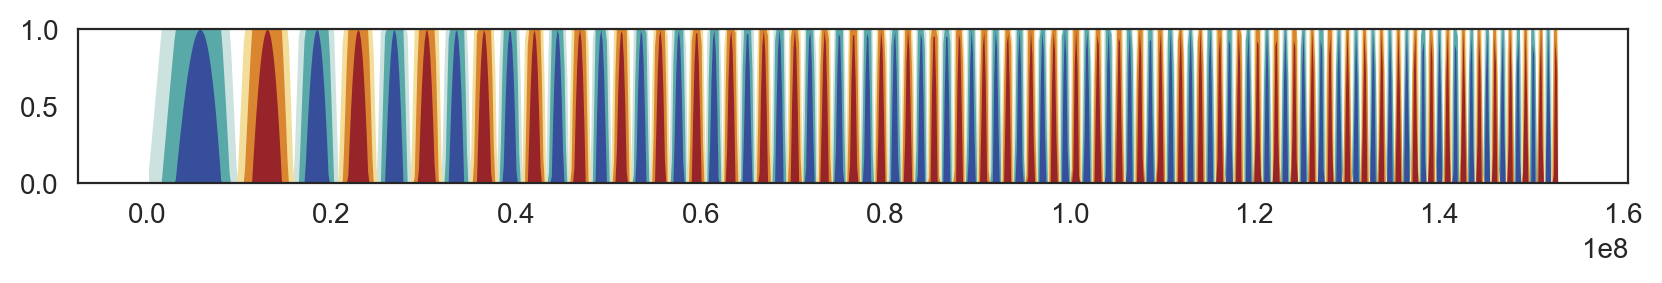

In [42]:


fig, ax = plt.subplots(1, 1, figsize=(10, 1))
plt.ylim(0, 1)

horizonplot(df, y='y', x='x', offset=0, height=1, ax=ax)
#ax.set_axis_off()

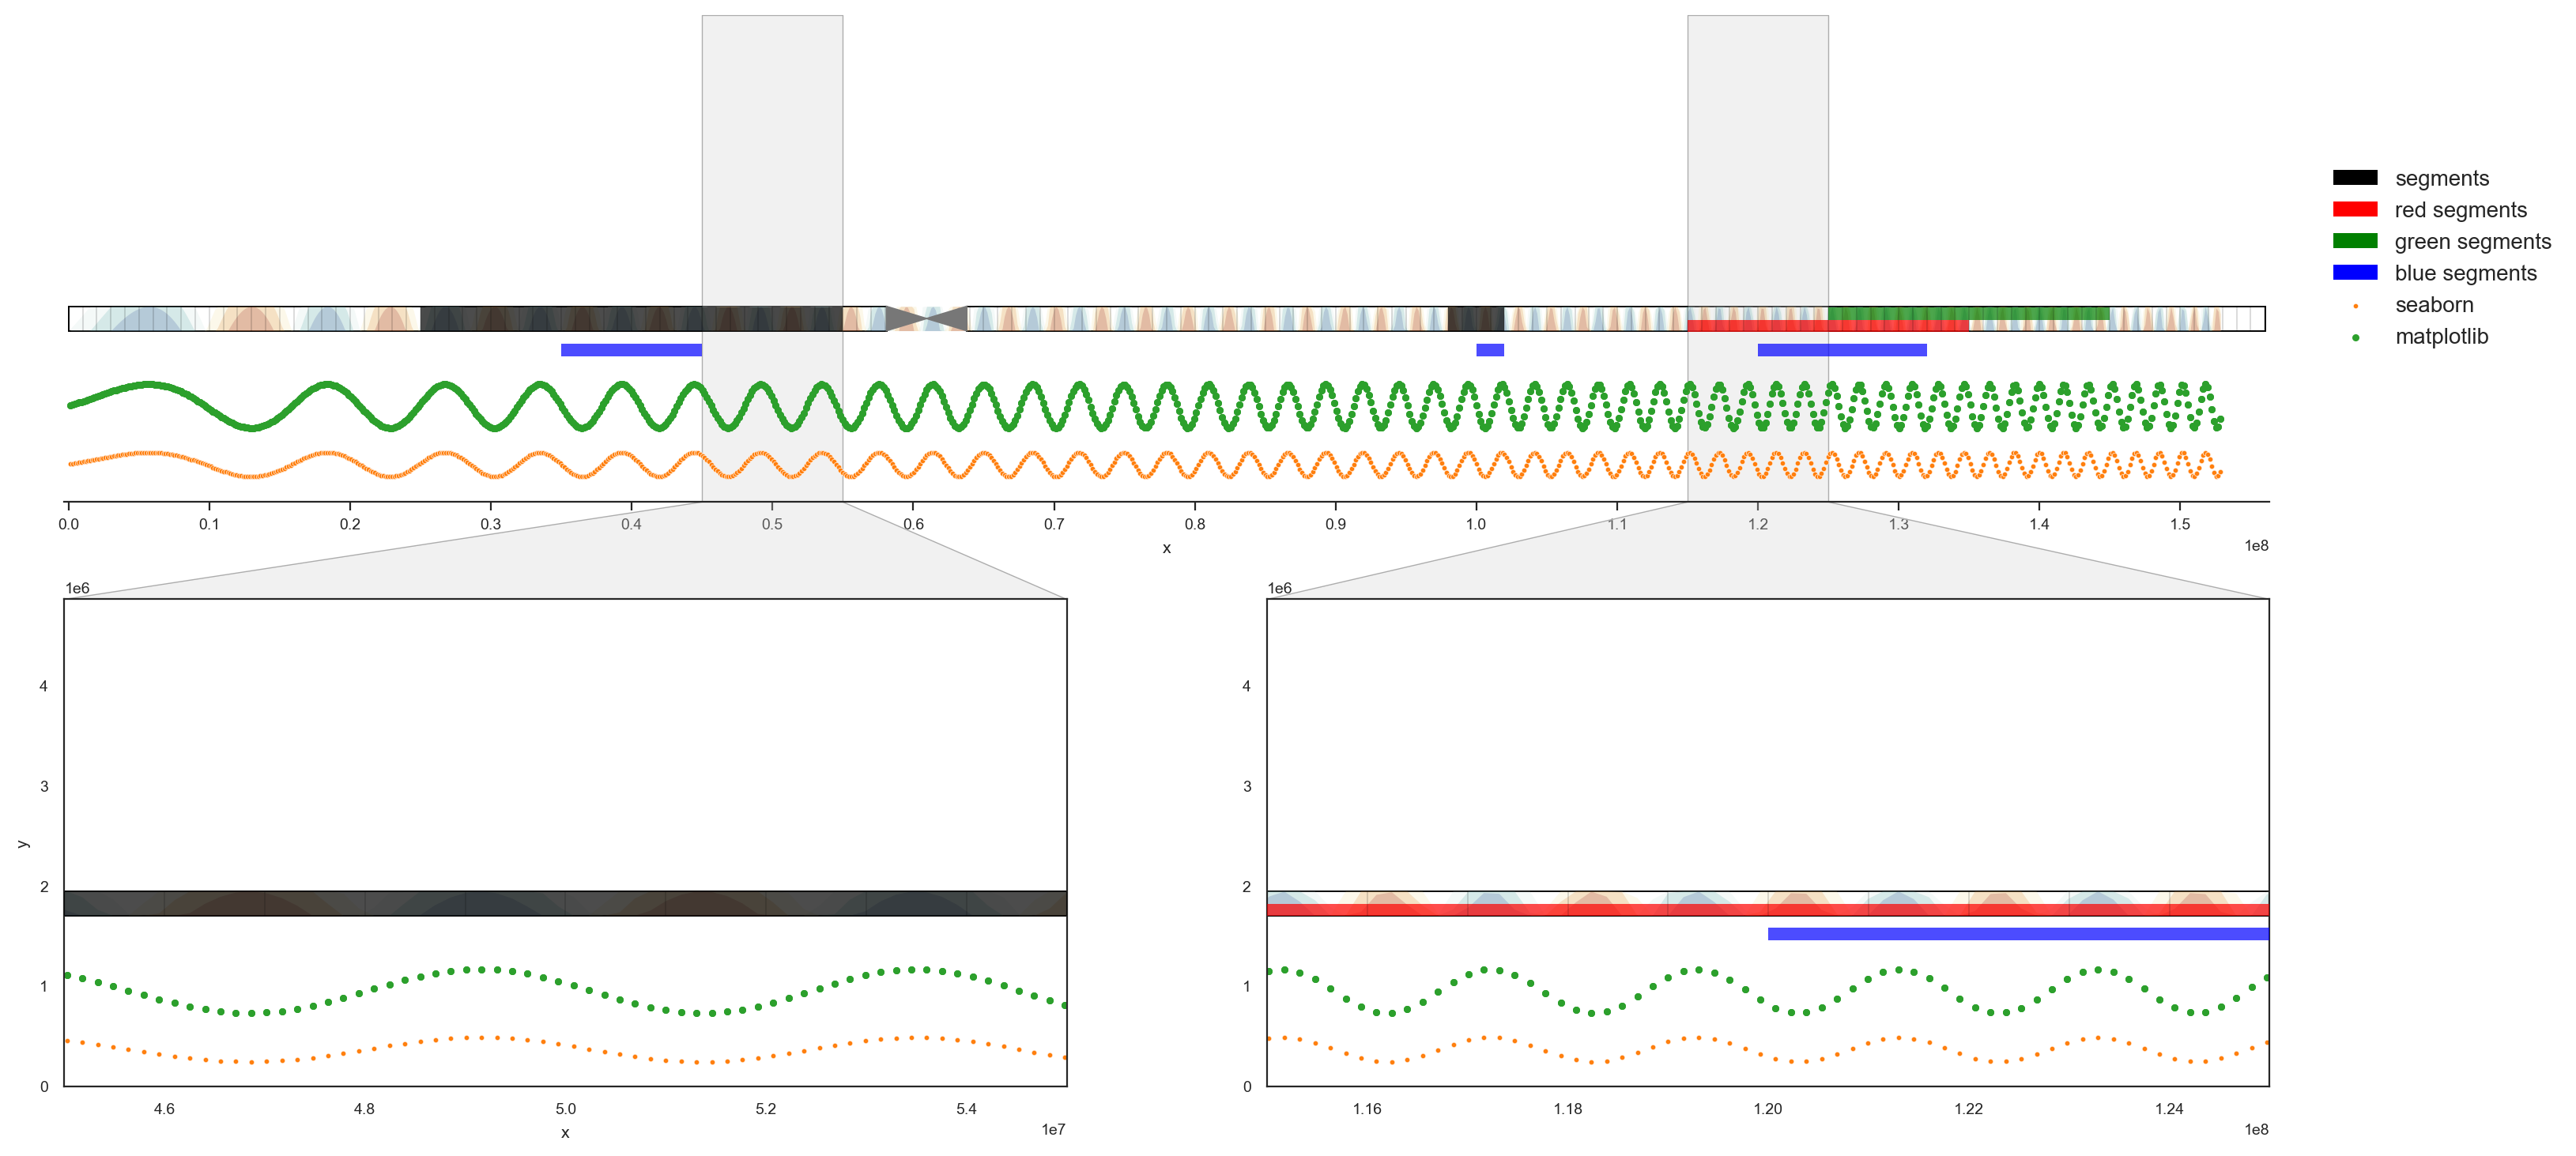

In [147]:
ci = ChromIdeogram('chrX', axes_width_inches=18, axes_height_inches=4, ylim=(0, 10), 
                   rel_font_height=0.01, hspace=0.2, wspace=None,
                   zooms=[(45_000_000, 55_000_000), 
                          # (65_000_000, 90_000_000), 
                           (115_000_000, 125_000_000),
                         ]) 

ci.draw_chromosomes(base=3.5, height=0.5, facecolor='none')

# ci.add_labels(annot, 
#               colored = xi_escape_genes,
#               bold = accel_reg_genes,
# #              italic = spermatid_expr_genes,
#               filled = cDEG_genes,
# #              bold = nDEG_genes + nDEG_genes,
#               # bold=['ZNF711', 'COX7B', 'PGK1'], 
#               # italic = ['TBX22'], 
#               # colored = ['NEXMIF', 'ATRX'],
#               # framed = ['MAOA', 'ATRX'],
#               # filled = ['PCDH19', 'ATRX'],
#              )

# ci.map_fun(horizonplot, data=df, x='x', y='y', offset=0, height=1000000)
ci.horizon(data=df, x='x', y='y', base=3.5, height=0.5, alpha=0.2)




ci.add_segments([('chrX', 25e6, 55e6), 
                 ('chrX', 98e6, 102e6)], label='segments', alpha=0.7)
ci.add_segments([('chrX', 115e6, 135e6)], facecolor='red', base=3.5, height=0.25, label='red segments', alpha=0.7)
ci.add_segments([('chrX', 125e6, 145e6)], facecolor='green', base=3.75, height=0.25, label='green segments', alpha=0.7)
ci.add_segments([('chrX', 35e6, 45e6), 
                 ('chrX', 100e6, 102e6), 
                 ('chrX', 120e6, 132e6)], facecolor='blue', base=3, height=0.25, label='blue segments', alpha=0.7)

ci.add_vlines()
ci.map_fun(sns.scatterplot, data=df, x='x', y='y', yaxis=(0.5, 1), s=5, c='C1', label='seaborn')
ci.map_method(Axes.scatter, data=df, x='x', y='y', yaxis=(1.5, 2.4), s=5, c='C2', label='matplotlib')
ci.legend()

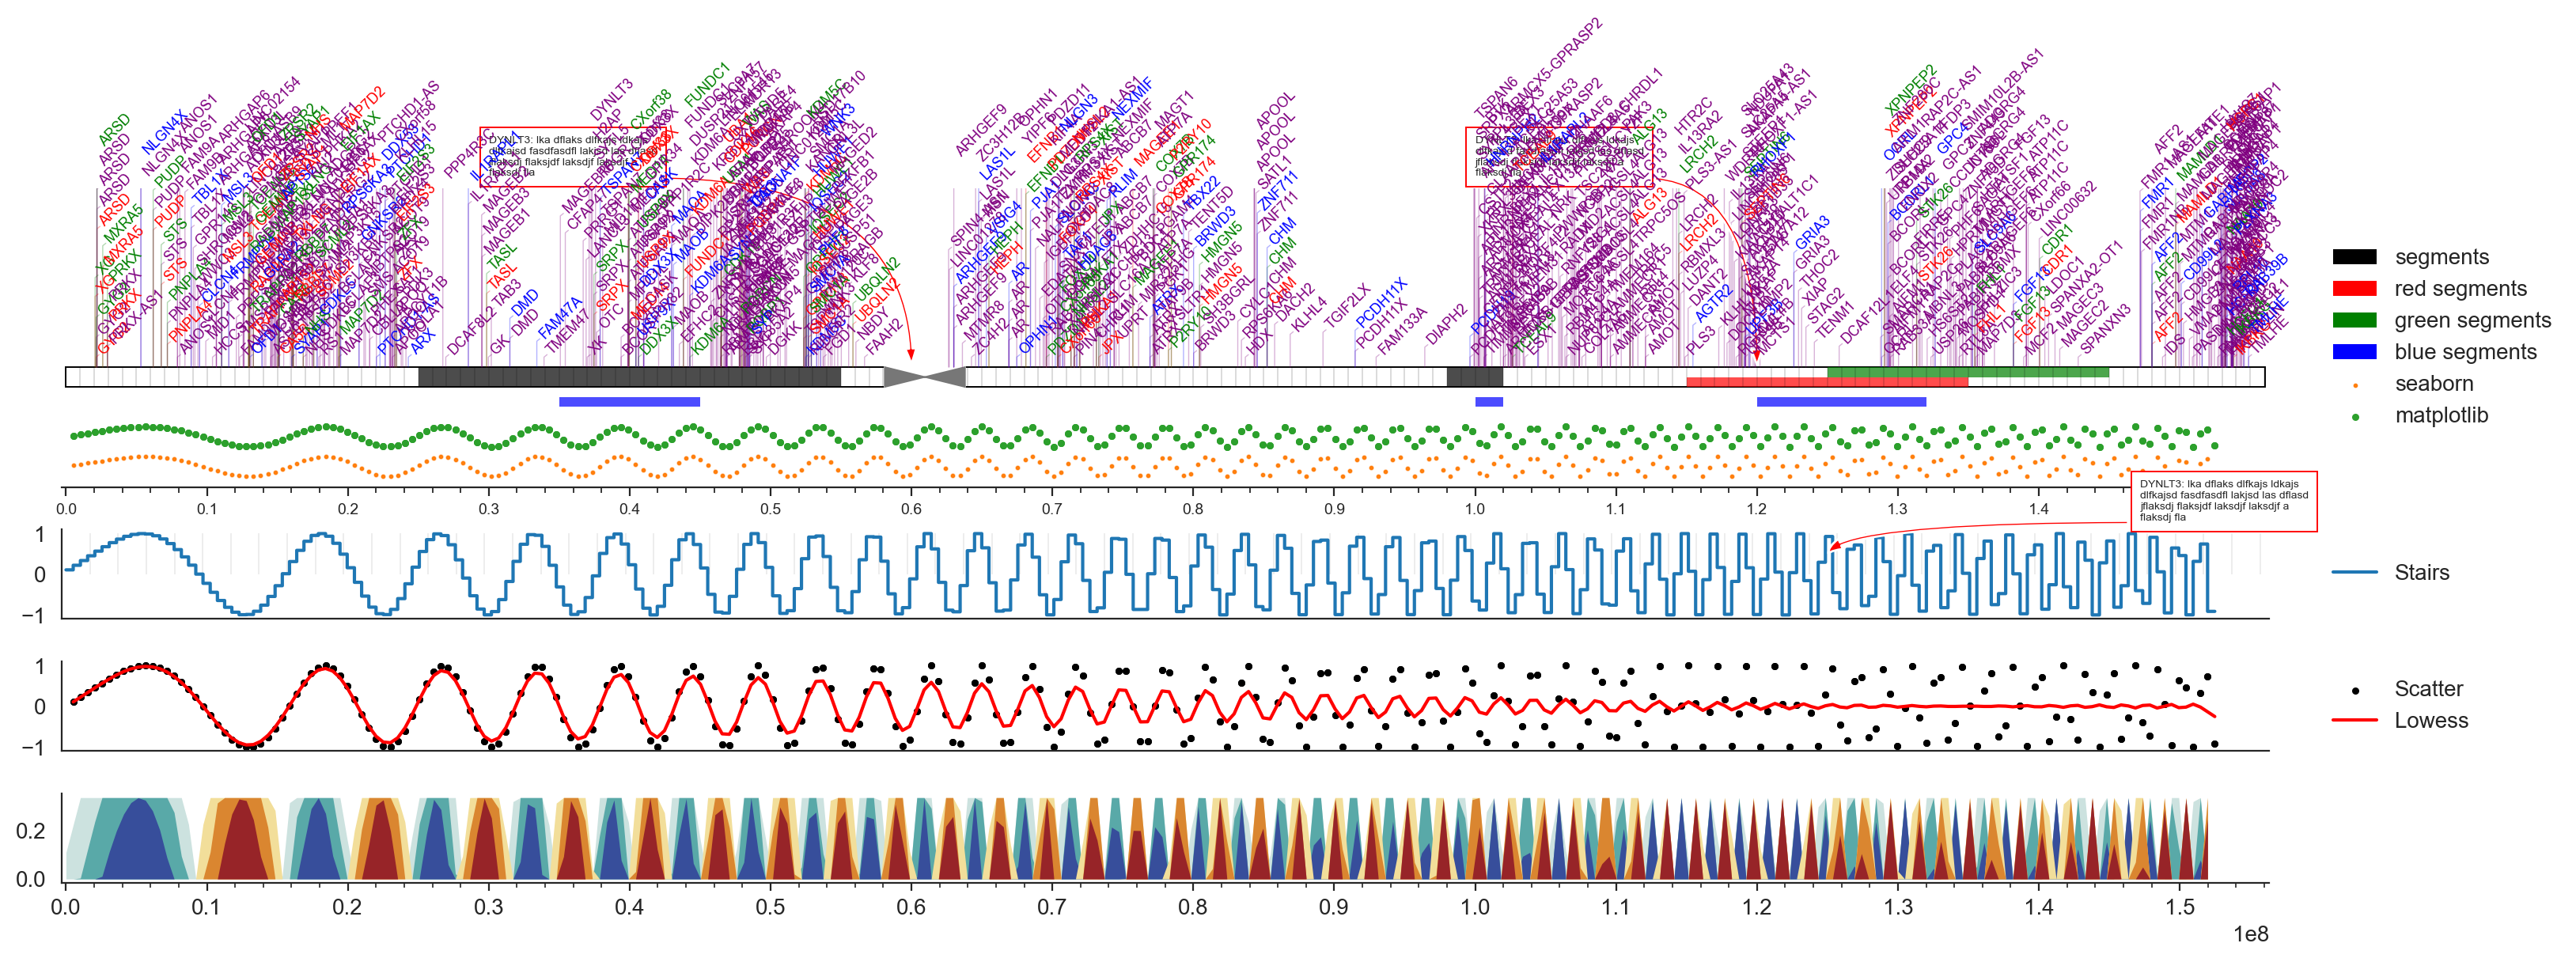

In [397]:
##########################################################################################
# interface
##########################################################################################

ci = ChromIdeogram('chrX', axes_width_inches=18, axes_height_inches=3, ylim=(0, 3), rel_font_height=0.03) # plots chromosome

# ci.draw_chromosomes(base=1, height=0.10, facecolor='lightgray')
ci.draw_chromosomes(base=1, height=0.20, facecolor='none')

ci.add_labels(annot)

ci.add_segments([('chrX', 25e6, 55e6), 
                 ('chrX', 98e6, 102e6)], label='segments', alpha=0.7)
ci.add_segments([('chrX', 115e6, 135e6)], facecolor='red', base=1, height=0.1, label='red segments', alpha=0.7)
ci.add_segments([('chrX', 125e6, 145e6)], facecolor='green', base=1.1, height=0.1, label='green segments', alpha=0.7)
ci.add_segments([('chrX', 35e6, 45e6), 
                 ('chrX', 100e6, 102e6), 
                 ('chrX', 120e6, 132e6)], facecolor='blue', base=0.8, height=0.1, label='blue segments', alpha=0.7)

ci.add_vlines()

# plot using function that takes data and column name keyword args for dimensions (like seaborn's sns.scatterplot)
ci.map_fun(sns.scatterplot, data=df, x='x', y='y', yaxis=(0.1, 0.3), s=5, c='C1', label='seaborn')

# plot using matplotlib Axes method that x and y positional arguments (like matplotlib's Axes.scatter)
ci.map_method(Axes.scatter, data=df, x='x', y='y', yaxis=(0.4, 0.6), s=5, c='C2', label='matplotlib')

ci.legend()

##########################################################################################
# add axis
##########################################################################################

new_ax, new_ax2, new_ax3 = ci.add_axes(3, height_ratio=0.3, hspace=0.3)


new_ax.vlines(list(range(*map(int, new_ax.get_xlim()), 2_000_000)), *new_ax.get_ylim(), color='gray', linewidth=0.1)

# new_ax.plot(np.linspace(*new_ax.get_xlim(), 100), np.random.random(100), label='Line')
_df = stairs(df)
new_ax.plot(_df.pos, _df.y, label='Stairs')
new_ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize="10", frameon=False) ;

# new_ax2.scatter(np.linspace(*new_ax.get_xlim(), 100), np.random.random(100), s=5, label='Scatter')
new_ax2.scatter(df.x, df.y, s=5, c='black',label='Scatter')
add_lowess(df.x, df.y, ax=new_ax2, frac=0.02, c='red', label='Lowess')
new_ax2.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize="10", frameon=False) ;


horizonplot(df, y='y', ax=new_ax3)


##########################################################################################
# info annotation
##########################################################################################

from matplotlib.text import OffsetFrom
import textwrap

strs = "DYNLT3: lka dflaks dlfkajs ldkajs dlfkajsd fasdfasdfl lakjsd las dflasd jflaksdj flaksjdf laksdjf laksdjf a flaksdj fla"

annot_kwargs=dict(fontsize=5, ha="left", va="bottom",
             bbox=dict(
                 # fc="0.97", 
                 fc="w",
                 ec="red",
                       # alpha=0.2, 
                 linewidth=0.7),

    arrowprops=dict(
        facecolor='red', # color of arrow
        shrink=0.01, # distance from point
        width=1.5, # width of arrow
        headwidth=5, # width of arrow head
        headlength=7, # length of arrow head
        connectionstyle="angle3,angleA=0,angleB=-90", 
        # alpha=0.7,
    ) 
                  
             # arrowprops=dict(facecolor='red', arrowstyle="fancy", 
             #                 connectionstyle="angle3,angleA=0,angleB=-90", alpha=0.9)
                  
                 )

ci.ax.annotate(textwrap.fill(strs, 40), xy=(60000000, ci.map_y(1.2, ci.ax)), xytext=(30000000, ci.map_y(3.1, ci.ax)), xycoords="data", textcoords="data", **annot_kwargs)
           
ci.ax.annotate(textwrap.fill(strs, 40), xy=(120000000, ci.map_y(1.2, ci.ax)), xytext=(100000000, ci.map_y(3.1, ci.ax)), xycoords="data", textcoords="data", **annot_kwargs) ;

new_ax.annotate(textwrap.fill(strs, 40), xy=(0.8, 0.7), xytext=(800, 200), xycoords="axes fraction",
             textcoords=OffsetFrom(ax.bbox, (0, 0), "points"), **annot_kwargs) ;


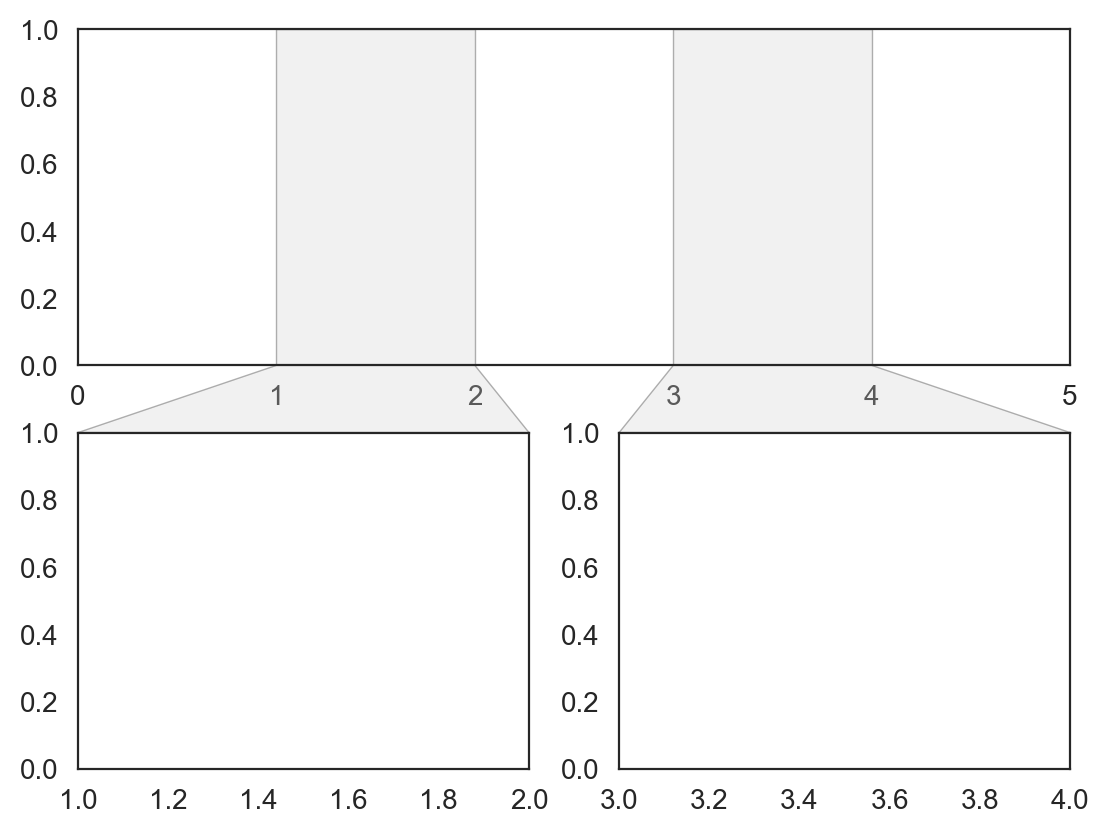

In [394]:
import matplotlib.pyplot as plt

from matplotlib.transforms import (Bbox, TransformedBbox,
                                   blended_transform_factory)
from mpl_toolkits.axes_grid1.inset_locator import (BboxConnector,
                                                   BboxConnectorPatch,
                                                   BboxPatch)


def connect_bbox(bbox1, bbox2,
                 loc1a, loc2a, loc1b, loc2b,
                 prop_lines, prop_patches=None):
    if prop_patches is None:
        prop_patches = {
            **prop_lines,
            "alpha": prop_lines.get("alpha", 1) * 0.2,
            "clip_on": False,
        }

    c1 = BboxConnector(
        bbox1, bbox2, loc1=loc1a, loc2=loc2a, clip_on=False, **prop_lines)
    c2 = BboxConnector(
        bbox1, bbox2, loc1=loc1b, loc2=loc2b, clip_on=False, **prop_lines)

    bbox_patch1 = BboxPatch(bbox1, ec='none', fc='none')
    bbox_patch2 = BboxPatch(bbox2, **prop_patches)

    p = BboxConnectorPatch(bbox1, bbox2,
                           loc1a=loc1a, loc2a=loc2a, loc1b=loc1b, loc2b=loc2b,
                           clip_on=False,
                           **prop_patches)

    return c1, c2, bbox_patch1, bbox_patch2, p




def zoom_effect(ax1, ax2, **kwargs):
    """
    ax1 : the main Axes
    ax1 : the zoomed Axes

    Similar to zoom_effect01.  The xmin & xmax will be taken from the
    ax1.viewLim.
    """

    tt = ax1.transScale + (ax1.transLimits + ax2.transAxes)
    trans = blended_transform_factory(ax2.transData, tt)

    mybbox1 = ax1.bbox
    mybbox2 = TransformedBbox(ax1.viewLim, trans)

    prop_patches = {**kwargs, 'ec': 'black', 'fc': 'lightgray', 'alpha': 0.3, 'linewidth': 0.5}

    c1, c2, bbox_patch1, bbox_patch2, p = connect_bbox(
        mybbox1, mybbox2,
        loc1a=2, loc2a=3, loc1b=1, loc2b=4,
        prop_lines=kwargs, prop_patches=prop_patches)

    ax1.add_patch(bbox_patch1)
    ax2.add_patch(bbox_patch2)
    ax2.add_patch(c1)
    ax2.add_patch(c2)
    ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p


axs = plt.figure().subplot_mosaic([
    ["main", "main"],
    ["zoom1", "zoom2"],
])

axs["main"].set(xlim=(0, 5))
zoom_effect(axs["zoom1"], axs["main"])
axs["zoom1"].set(xlim=(1, 2))
axs["zoom2"].set(xlim=(3, 4))
zoom_effect(axs["zoom2"], axs["main"])

plt.show()

# the issue seems to be that I compute ylimits using the input data to horizonplot, not the data it plots...

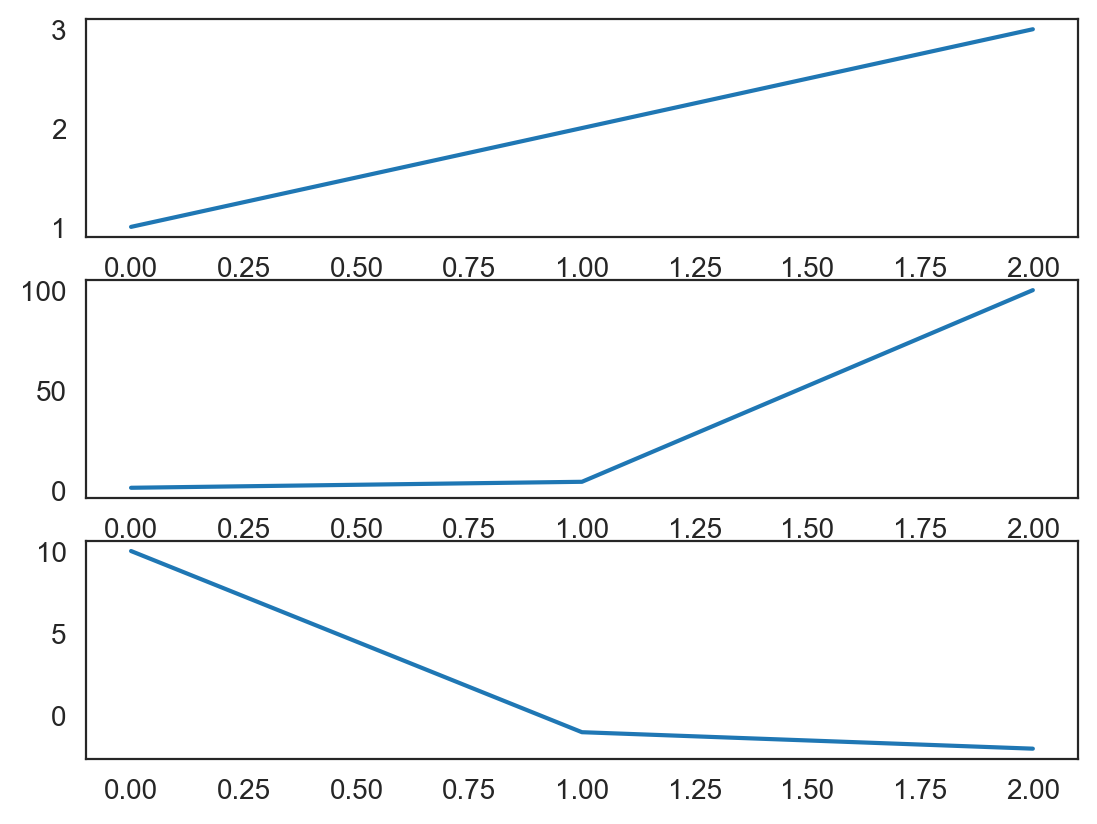

In [16]:
import matplotlib.pyplot as plt
from matplotlib import gridspec


class DrawExample():

    def __init__(self, initial_data) -> None:
        """Constructs a DrawExample for one column and multiple rows.

        Note that subplots are added to the bottom.
        """
        self.fig = plt.figure()

        # Start with one subplot
        self.row = 1
        ax = self.fig.add_subplot(self.row, 1, 1)
        ax.plot(initial_data)

    def plot_bottom(self, data: list) -> None:
        """Plots the data to a new subplot at the bottom."""
        self.row += 1
        gs = gridspec.GridSpec(self.row, 1)

        # Reposition existing subplots
        for i, ax in enumerate(self.fig.axes):
            ax.set_position(gs[i].get_position(self.fig))
            ax.set_subplotspec(gs[i])

        # Add new subplot
        new_ax = self.fig.add_subplot(gs[self.row-1])
        new_ax.plot(data)

    def show(self) -> None:
        plt.show()


draw = DrawExample([1, 2, 3])
draw.plot_bottom([1, 4, 100])
draw.plot_bottom([10, -1, -2])
draw.show()

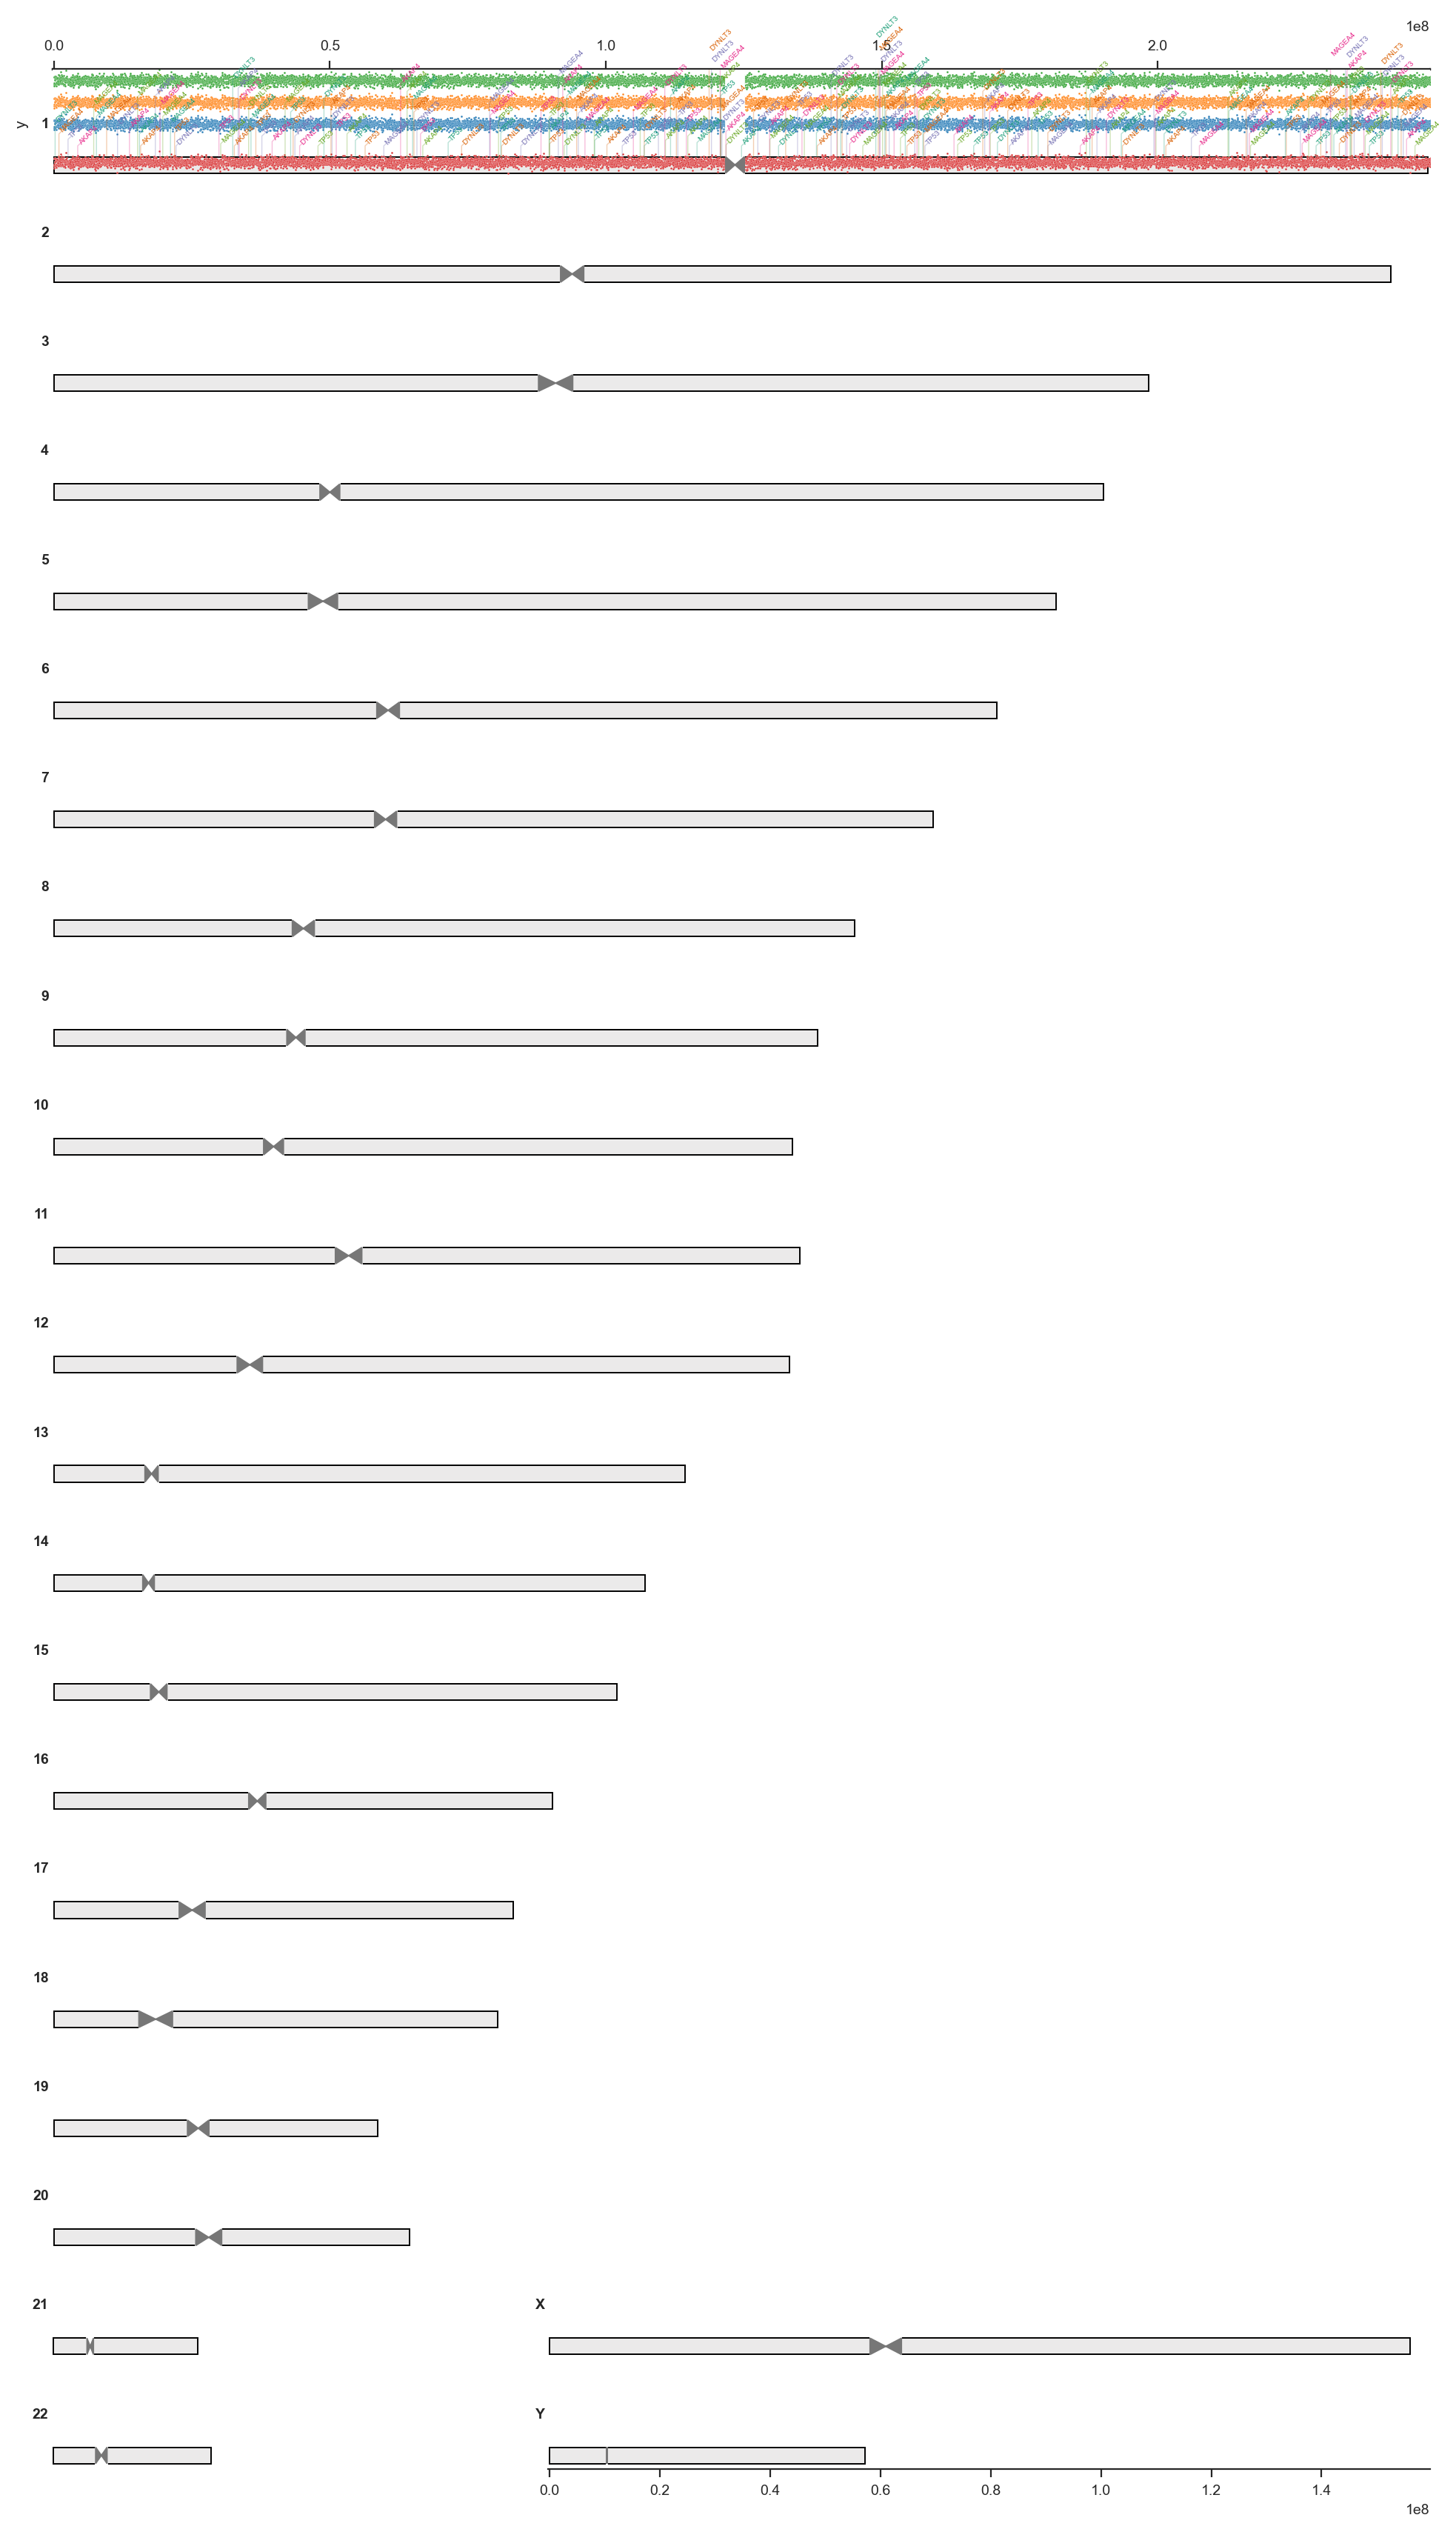

In [50]:
ci = GenomeIdeogram() # plots chromosome
ci.draw_chromosomes(base=0.05, height=0.15)
ci.add_labels(annot, y0=0.2, y1=0.3)
#ci.map(plt.scatter, data=df, x='x', y='y', yaxis=(0.5, 0.7))
ci.map_dataframe(sns.scatterplot, data=df, x='x', y='y', yaxis=(0.4, 0.6), s=1)
ci.map_dataframe(sns.scatterplot, data=df, x='x', y='y', yaxis=(0.6, 0.8), s=1)
ci.map_dataframe(sns.scatterplot, data=df, x='x', y='y', yaxis=(0.8, 1.0), s=1)
ci.map_dataframe(sns.scatterplot, data=df, x='x', y='y', yaxis=(0.05, 0.25), s=1)

In [799]:
# import pandas as pd
# import math
# from matplotlib.artist import Artist


# axes_height = 1e4 # relative to length of chrom one
# max_chrom_size = 1e5
# aspect = axes_height / chrom_size

# fig_width_inches = 8
# axes_height_inches = fig_width * aspect
# fig_height = axes_height_inches * nr_rows

# nr_rows = 11
# fig, axes = plt.subplots(nr_rows, 1, figsize=(fig_width, fig_width*aspect*nr_rows), sharex=True, sharey=True)
# plt.subplots_adjust(hspace=0)
# ax = axes[0]

# xlim = (0, max_chrom_size)
# ylim = (0, 6)
# scaled_y_lim = xlim[0] * aspect, xlim[1] * aspect
# ax.set_xlim(xlim)
# ax.set_ylim(scaled_y_lim)
# plt.yticks([])
# y_unit = -sub(*scaled_y_lim) / -sub(*ylim)

# rel_font_height = 0.1
# font_size = rel_font_height * axes_height_inches / point_size


# def draw_text(x_pos, y_pos, text, font_size, rel_font_height, ax, y_line_bottom=0):
 
#     ax.text(x_pos, y_pos, 'Tester', fontsize=font_size, 
#                 horizontalalignment='left',# weight='bold',
#                 verticalalignment='bottom', 
#                 rotation=45, zorder=3, 
#                 bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))
#     (_, a), (_, b) = ax.transAxes.transform([(0, 0), (0, rel_font_height / 2)])
#     z = b - a    
#     z = 300
#     z = y_unit/6

#     ax.plot((x_pos, x_pos, x_pos+z),
#             (y_line_bottom, y_pos, y_pos+z), 
#             linewidth=0.5, color='gray')


# def get_polygon(text:str, x_pos:int, y_pos:float, font_size:float, ax:matplotlib.axes.Axes) -> Polygon:

#     y_pos = y_pos * y_unit
#     # x_pos, y_pos = chrom_size/2, 2*y_unit
    
#     # ax.scatter([x_pos], [y_pos], marker='X', color='black')
    
    
#     t = ax.text(x_pos, y_pos, 'Tester', fontsize=font_size, 
#                 horizontalalignment='left',# weight='bold',
#                 verticalalignment='bottom', 
#                 rotation=0, zorder=3, 
#                 bbox=dict(boxstyle='square,pad=0', fc='none', ec='none', alpha=0.4))
#     # t.set_visible(False)
    
#     transf = ax.transData.inverted()
#     bb = t.get_window_extent(renderer = fig.canvas.get_renderer())
#     bbt = bb.transformed(transf)
#     coords = bbt.get_points()
    
#     Artist.remove(t)
    
#     (x0, y0), (x1, y1) = coords
#     coords = np.array([(x0, y0), (x0, y1), (x1, y1), (x1, y0)])
#     # ax.scatter(*coords.T, c='red')
    
#     # ax.scatter(*zip(*coords), transform=ax.transAxes, s=1, color='green', zorder=3)
    
#     x, y = zip(*coords)
#     df = pd.DataFrame(dict(x=x, y=y))
#     df['y'] -= y_pos
#     df['x'] -= x_pos
#     dfx = df['x']*math.cos(math.radians(45))-df['y']*math.sin(math.radians(45))
#     df['y'] = df['x']*math.sin(math.radians(45))+df['y']*math.cos(math.radians(45))
#     df['x'] = dfx
#     df['y'] += y_pos
#     df['x'] += x_pos
    
#     #df['x'] -= df['x'][1] - df['x'][0]
    
#     coords = np.array(list(zip(df.x, df.y)))
    
#     x_pos, y_pos = df['x'][0] - (df['x'][0] - df['x'][1]), df['y'][0]
#     # _ = ax.text(x_pos, y_pos, 'Tester', fontsize=font_size, 
#     #             horizontalalignment='left',# weight='bold',
#     #             verticalalignment='bottom', 
#     #             rotation=45, zorder=3, 
#     #             bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))
    
#     # ax.scatter(*coords.T, c='blue')
    
#     # ax.plot(*zip(*coords), linewidth=0.2)

#     return x_pos, y_pos, Polygon([Point(x, y) for x, y in zip(df.x, df.y)])


# annot = [(x, 'AKAP4') for x in range(1, int(max_chrom_size), int(max_chrom_size/200))]

# for i, ax in enumerate(axes):
#     annot = [(x, 'AKAP4') for x in range(1, int(max_chrom_size), int(max_chrom_size/(10*(i+1))))]

#     polybuff = []
#     for pos, name in annot:
#         x, y, poly = get_polygon(name, pos, 1, rel_font_height, ax)

#         while any(is_polygons_intersecting(poly, p) for p in polybuff):
#             nudge = 0.1 * y_unit
#             y += nudge
#             poly.nudge_y(nudge)
#         draw_text(x, y, name, font_size, rel_font_height, ax)

#         if len(polybuff) > 5:
#             del polybuff[0]
#         polybuff.append(poly)


[[0.2        0.2       ]
 [0.27711694 0.30281385]]
[[0.51148154 0.92042049]
 [0.55200529 0.73124667]
 [0.6914605  0.9821989 ]
 [0.65093675 1.17137271]]
1.3419913419913418


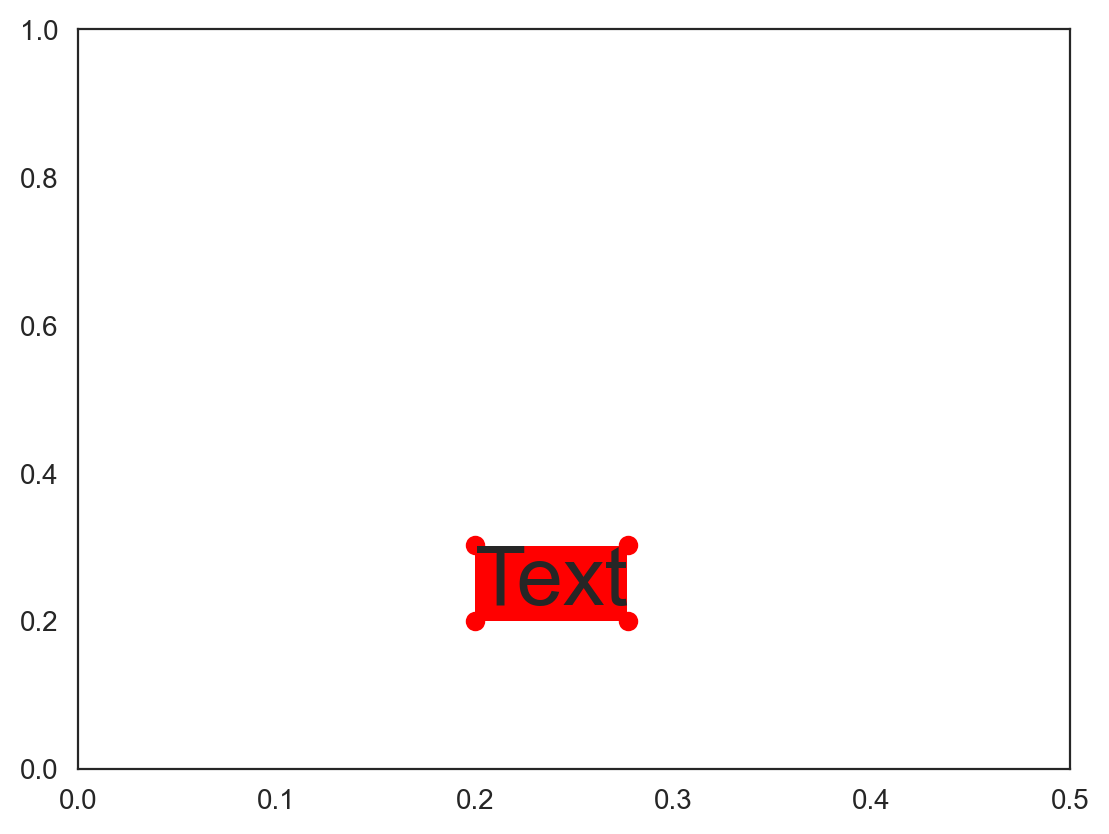

In [559]:
import matplotlib.transforms

from matplotlib.transforms import Bbox
fig, ax = plt.subplots()
plt.xlim(0, 0.5)
plt.ylim(0, 1)

t = ax.text(0.2, 0.2, 'Text', fontsize=30, horizontalalignment='left',# weight='bold',
                         verticalalignment='bottom', rotation=0, zorder=3, bbox=dict(boxstyle='square,pad=0', fc='red', ec='none'))
transf = ax.transData.inverted()
bb = t.get_window_extent(renderer = fig.canvas.get_renderer())
bbt = bb.transformed(transf)
coords = bbt.get_points()
print(coords)
(x0, y0), (x1, y1) = coords
plt_coords = np.array([(x0, y0), (x0, y1), (x1, y1), (x1, y0)])

ax.scatter(*plt_coords.T, c='red')


from operator import sub
aspect_ratio = sub(*ax.get_ylim()) / sub(*ax.get_xlim())

#x0, y0 = coords[0]
# (x0, y0), (x1, y2) = coords
trafo = matplotlib.transforms.Affine2D().rotate_deg_around(x0,y0,45).skew(1, 1.3)#.scale(0.5)

coords = trafo.transform([(x0, y0), (x0, y1), (x1, y1), (x1, y0)])
# coords = trafo.transform([(x0, y0), (x1, y1)])
# coords = trafo.transform(coords)
print(coords)

ax.scatter(*coords.T, zorder=10)

disp_ratio = ax.get_data_ratio()
bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
disp_ratio = bbox.width / bbox.height
print(disp_ratio)



(x0, y0), (x0, y1), (x1, y1), (x1, y0) = coords
coords = np.array([(x0, y0), (x0, y1), (x1, y1), (x1, y0)])

ax.scatter(*coords.T)


Polygon([Point(x0, y0), Point(bbt.xmin, b[1]+(b[0]-bbt.xmin)), Point(b[2], b[3]), Point(bbt.xmax, b[3]-(b[0]-bbt.xmin))])


#Bbox.count_overlaps

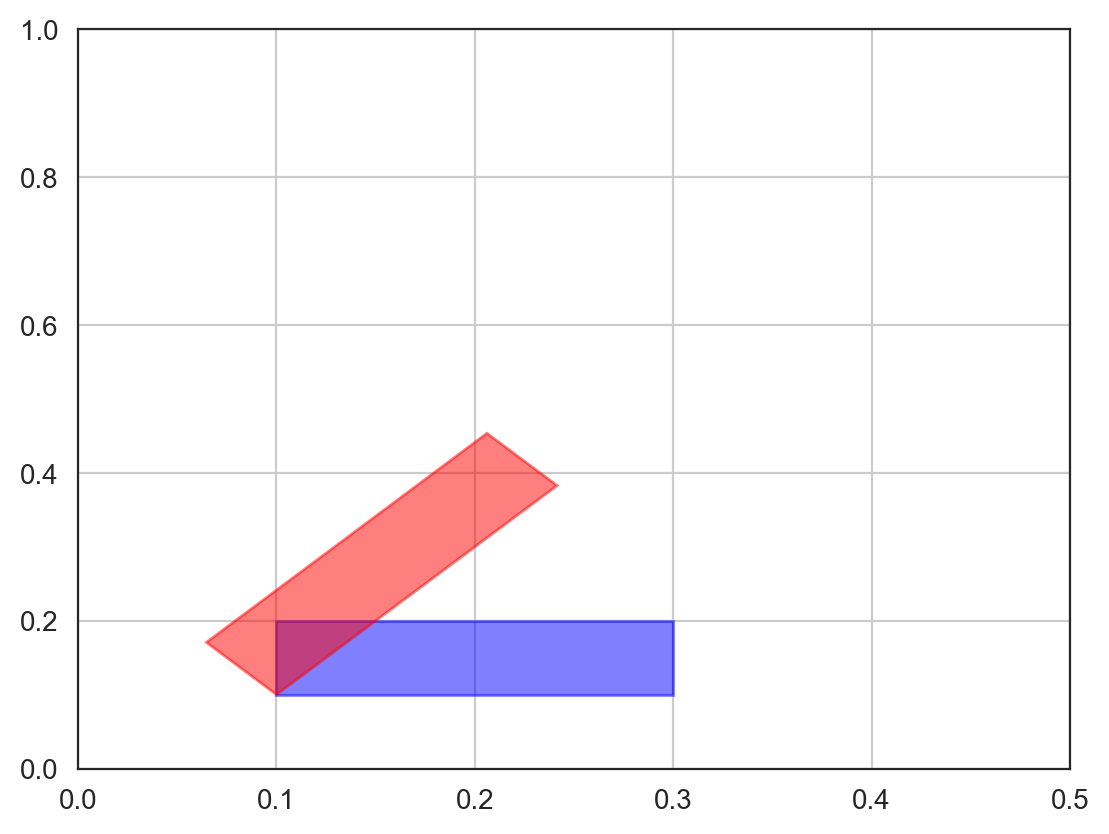

In [560]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.transforms as transforms

fig, ax = plt.subplots()

# [[0.25574077 0.46021024]
#  [0.29626452 0.27103643]
#  [0.43571973 0.52198865]
#  [0.39519598 0.71116247]]

# [[0.1        0.1       ]
#  [0.17711694 0.20281385]]
r1 = patches.Rectangle((0.1, 0.1), 0.2, 0.1, color="blue", alpha=0.5)
r2 = patches.Rectangle((0.1, 0.1), 0.2, 0.1, color="red", alpha=0.5)


p = 0.1, 0.1 # rotate around this point

x_lim = (0, 0.5)
y_lim = (0, 1)
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)

x_range = x_lim[1] - x_lim[0]
y_range = y_lim[1] - y_lim[0]
aspect_ratio = y_range / x_range

move_transform = transforms.Affine2D().translate(-p[0], -p[1])
inverse_move_transform = transforms.Affine2D().translate(p[0], p[1])
inverse_scale_transform = transforms.Affine2D().scale(1, 1 / aspect_ratio)
rotate_transform = transforms.Affine2D().rotate_deg(45)
scale_transform = transforms.Affine2D().scale(1, aspect_ratio)

total_transform = move_transform + inverse_scale_transform + rotate_transform + scale_transform + inverse_move_transform + ax.transData

r2.set_transform(total_transform)

ax.add_patch(r1)
ax.add_patch(r2)

# print(ax.transLimits.transform([(0.1, 0.1), (0.1, 0.2), (0.3, 0.2), (0.3, 0.1)]))
# print(total_transform.transform([(0.1, 0.1), (0.1, 0.2), (0.3, 0.2), (0.3, 0.1)]))
# print(r2.get_bbox())
# x0, y0, width, height = r2.get_bbox().bounds()
# print(x0, y0)
# coords = [(x0, y0), 
#           (x0 - sqrt(height**2 / 2), y0 + sqrt(height**2 / 2)), 
#           (x0 - sqrt(height**2 / 2) + sqrt(width**2 / 2), y0 + sqrt(height**2 / 2)) +  + sqrt(width**2 / 2), 
#           (x0 + sqrt(width**2 / 2), y0 + sqrt(width**2 / 2))]
# plt.scatter(*zip(*coords))

# coords = ((0.1, 0.1), (0.1, 0.2), (0.3, 0.2), (0.3, 0.1))
# plt.scatter(*zip(*coords))
# coords = total_transform.transform(coords)
# print(coords)
# plt.scatter(*zip(*coords))

plt.grid(True)
plt.show()

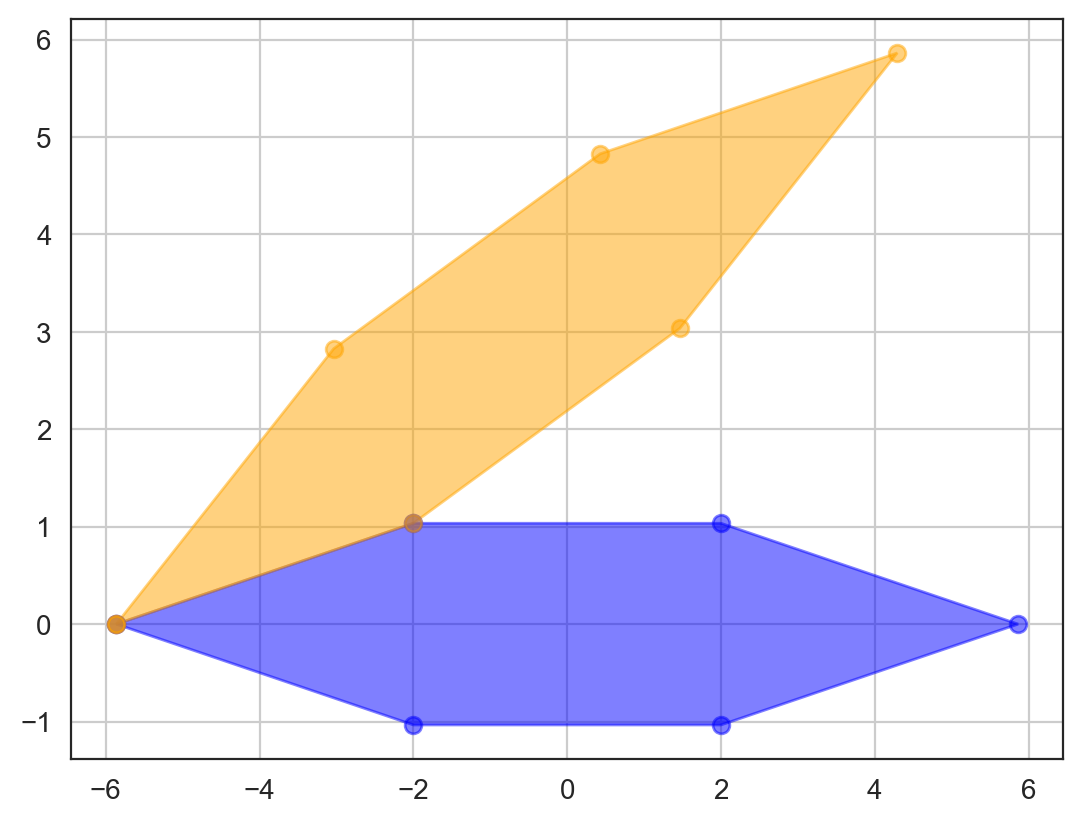

In [365]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
from math import *

#some helper values
p=4
theta=pi/6
x1 = p*cos(theta/2)
y1 = p*sin(theta/2)
vertices =[(-x1-p/2,0), (-p/2, y1), (p/2, y1), (x1+p/2, 0), (p/2, -y1), (-p/2, -y1)] 
midPoint = [3,4]
endPoint = (-x1-p/2,0)

#set up the plot
fig = plt.figure()
ax = fig.add_subplot(111)

#function to rotate and translate the standard shape to a new position
def plot_polygon(vertices, midPoint, theta, color):
    polygon = patches.Polygon(vertices, color=color, alpha=0.50) 
    r = mpl.transforms.Affine2D().rotate_around(midPoint[0],midPoint[1], theta)
    # t = mpl.transforms.Affine2D().translate(midPoint[0],midPoint[1])
    tra = r + ax.transData
    # r = mpl.transforms.Affine2D().rotate(theta)
    # t = mpl.transforms.Affine2D().translate(midPoint[0],midPoint[1])
    # tra = r + t + ax.transData
    polygon.set_transform(tra)
    ax.add_patch(polygon)

    return r.transform(polygon.xy)

p = plot_polygon(vertices, endPoint, 0, "blue")
#plot_polygon(vertices, midPoint, theta, "blue")
p_ = plot_polygon(vertices, endPoint, theta, "orange")

# print(p.get_xy())
# print(p_.get_xy())
# print(p.get_transform().transform(p.xy))
# print(p_.get_transform().transform(p_.xy))
#The correct answer is: tra.transform(poly.xy)


plt.scatter(*zip(*p), color='blue', alpha=0.5)
plt.scatter(*zip(*p_), color='orange', alpha=0.5)

# plt.xlim(-10, 10)
# plt.ylim(-10, 10)

plt.grid(True)

plt.show()

In [596]:
chrom_size = 12e5
ylim = (0, 3)
xlim = (0, chrom_size)
data_height = (ylim[1] - ylim[0])
data_width = (xlim[1] - xlim[0])
aspect = data_height / data_width
aspect
# data_width * aspect
# ylim = ylim * sub(*ylim) / sub(*xlim)
# chrom_size * sub(*ylim) / sub(*xlim)

2.5e-06

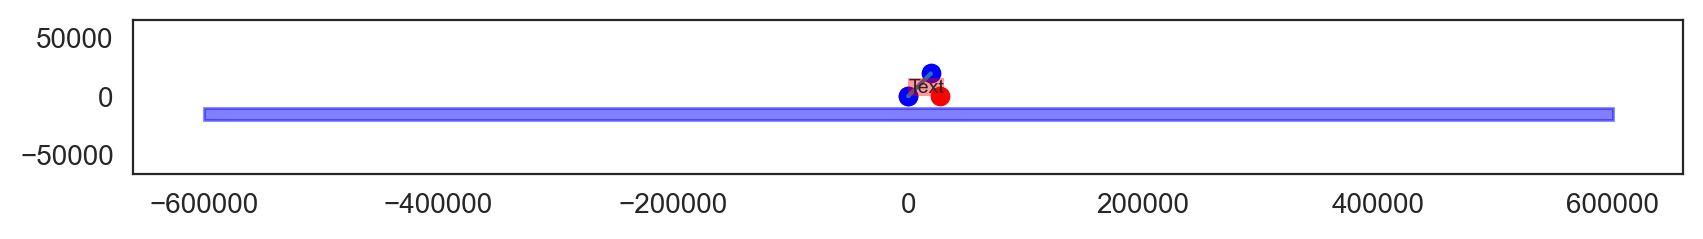

In [586]:
import pandas as pd
import math
from operator import sub
coords = [(0, 0), (0, 1e4), (3e4, 1e4), (3e4, 0)]


chrom_size = 12e5
ylim = np.array([0, 3])
xlim = np.array([0, chrom_size])
ylim = sub()sub(ylim) / sub(xlim) *

# fig, (ax, ax2) = plt.subplots(2, 1, figsize=(10, 1), sharex=True)
fig, ax = plt.subplots(1, 1, figsize=(10, 1), sharex=True)
ax.set_xlim(-6e5, 6e5)
ax.set_ylim(-6e4, 6e4)
ax.axis('equal')

# t = ax.text(0, 0, 'Text', fontsize=7, horizontalalignment='left',# weight='bold',
#                          verticalalignment='bottom', rotation=0, zorder=3, bbox=dict(boxstyle='square,pad=0', fc='red', ec='none', alpha=0.4))
# box = t.get_bbox_patch()
# fig.canvas.draw()
# ax.axis('equal')
# ax.set_xlim(-6e5, 6e5)
# ax.set_ylim(-4e5, 4e5)
# # coords = ax.transData.inverted().transform(box.get_window_extent())
# #coords = ax.transAxes.transform(coords)

# # print(coords)
# # print(ax.transLimits.transform(coords))

t = ax.text(0, 0, 'Text', fontsize=7, horizontalalignment='left',# weight='bold',
                         verticalalignment='bottom', rotation=0, zorder=3, bbox=dict(boxstyle='square,pad=0', fc='red', ec='none', alpha=0.4))
transf = ax.transData.inverted()
bb = t.get_window_extent(renderer = fig.canvas.get_renderer())
bbt = bb.transformed(transf)
coords = bbt.get_points()

(x0, y0), (x1, y1) = coords
coords = np.array([(x0, y0), (x0, y1), (x1, y1), (x1, y0)])
ax.scatter(*coords.T, c='red')

# ax.scatter(*zip(*coords), transform=ax.transAxes, s=1, color='green', zorder=3)

x, y = zip(*coords)
df = pd.DataFrame(dict(x=x, y=y))
dfx = df['x']*math.cos(math.radians(45))-df['y']*math.sin(math.radians(45))
df['y'] = df['x']*math.sin(math.radians(45))+df['y']*math.cos(math.radians(45))
df['x'] = dfx
coords = np.array(list(zip(df.x, df.y)))

ax.scatter(*coords.T, c='blue')

ax.plot(*zip(*coords))

# ax.axis('equal')
# ax.set_xlim(-6e5, 6e5)
# ax.set_ylim(-4e5, 4e5)

rect = patches.Rectangle((-6e5, -2e4), 12e5, 1e4, color="blue", alpha=0.5)
ax.add_patch(rect) ;

[[0.2        0.2       ]
 [1.97368952 0.30281385]]


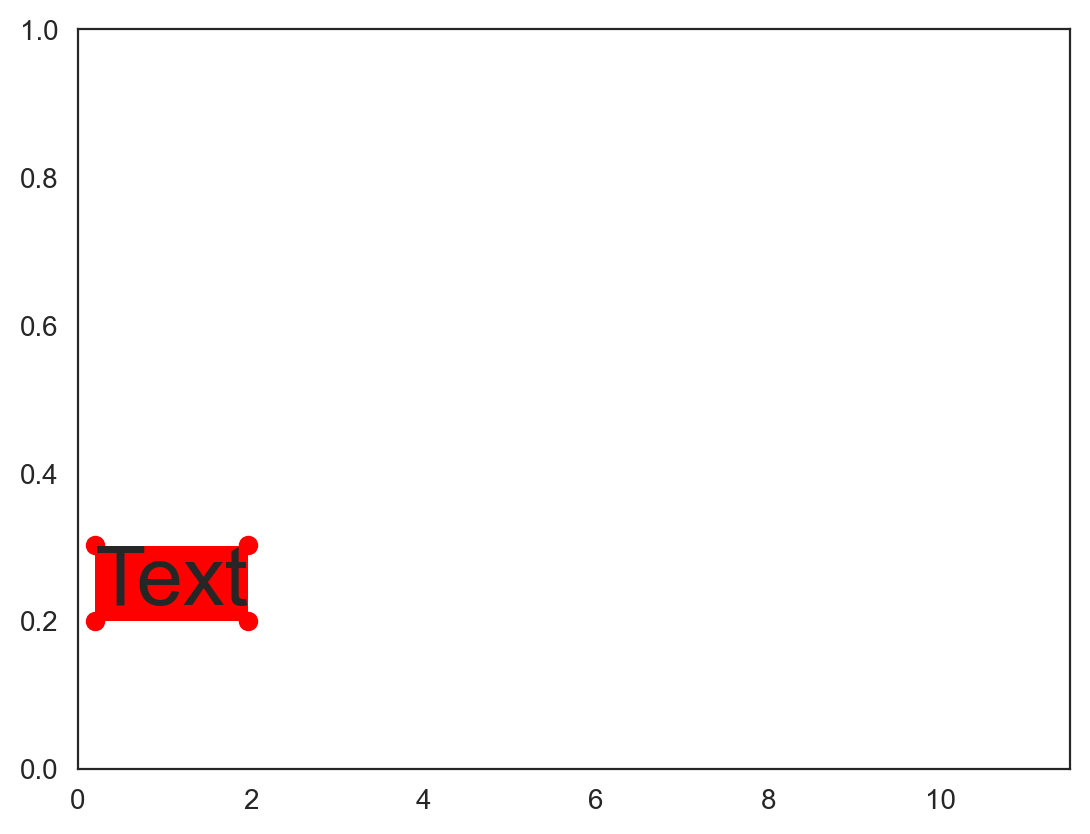

In [566]:
fig, ax = plt.subplots()
plt.xlim(0, 0.5)
plt.ylim(0, 1)
t = ax.text(0.2, 0.2, 'Text', fontsize=30, horizontalalignment='left',# weight='bold',
                         verticalalignment='bottom', rotation=0, zorder=3, bbox=dict(boxstyle='square,pad=0', fc='red', ec='none'))


transf = ax.transData.inverted()
bb = t.get_window_extent(renderer = fig.canvas.get_renderer())
bbt = bb.transformed(transf)
coords = bbt.get_points()
print(coords)
(x0, y0), (x1, y1) = coords
plt_coords = np.array([(x0, y0), (x0, y1), (x1, y1), (x1, y0)])

ax.scatter(*plt_coords.T, c='red')



[[0.1        0.1       ]
 [0.25716788 0.0862437 ]]
[[0.1        0.23      ]
 [0.25716788 0.2162437 ]]


AttributeError: 'NoneType' object has no attribute 'get_points'

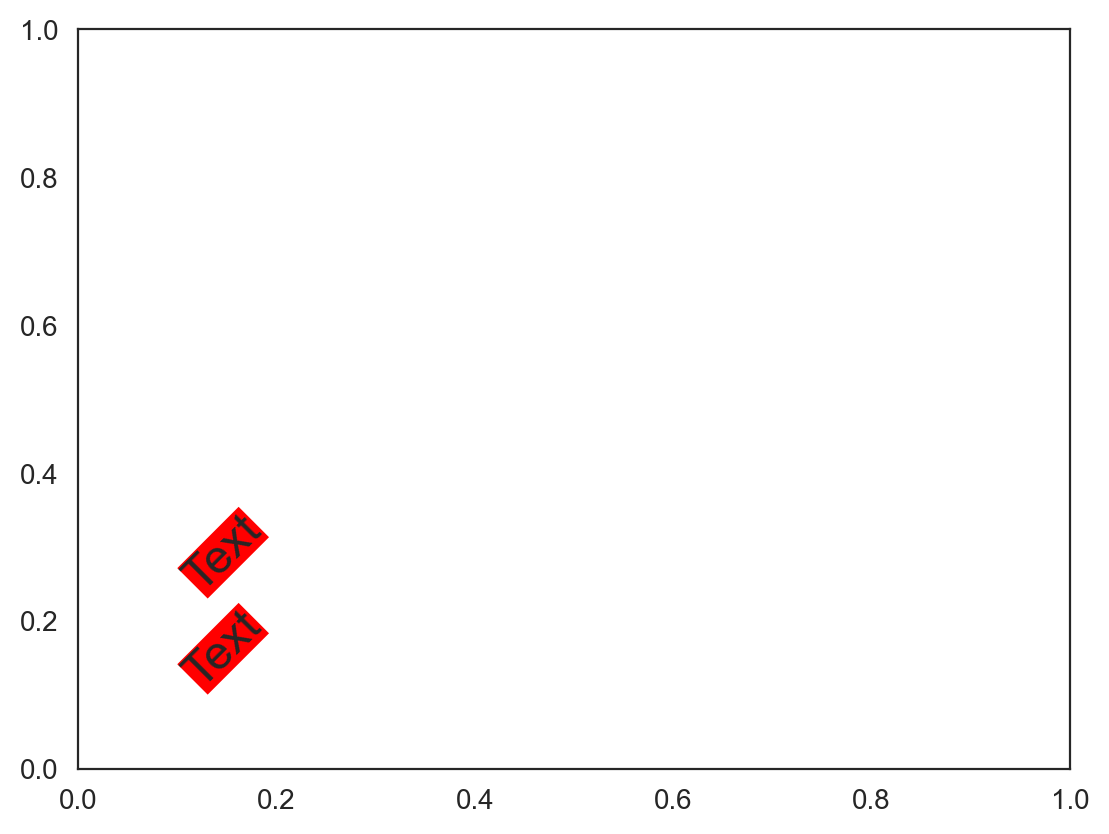

In [391]:
import matplotlib.transforms

from matplotlib.transforms import Bbox
fig, ax = plt.subplots()

def get_polygon(t):

    transf = ax.transData.inverted()
    bb = t.get_window_extent(renderer = fig.canvas.get_renderer())
    bbt = bb.transformed(transf)
    coords = bbt.get_points()

    x0, y0 = coords[0]
    trafo = matplotlib.transforms.Affine2D().rotate_around(x0,y0,-)
    print(trafo.transform(coords))

# bb = t.get_window_extent(renderer = fig.canvas.get_renderer())
    # coords = bb.get_points()
    # print(coords)
    # x0, y0 = coords[0]
    # print(x0, y0)
    # trafo = matplotlib.transforms.Affine2D().rotate_around(x0,y0,45)

    # coords = bb.get_points()
    # print(coords)
    # print(trafo.transform(coords))

    # transf = ax.transData.inverted()
    # bb = t.get_window_extent(renderer = fig.canvas.get_renderer())
    # bbt = bb.transformed(transf)
    # # return bbt
    # b = bbt.bounds
    # # print(dir(bbt), bbt.rotated(0.785398).corners())

    # return Polygon([Point(b[0], b[1]), Point(bbt.xmin, b[1]+(b[0]-bbt.xmin)), Point(b[2], b[3]), Point(bbt.xmax, b[3]-(b[0]-bbt.xmin))])
    # # return Polygon([Point(bbt.xmin, bbt.ymin), Point(bbt.xmin, bbt.ymin), Point(bbt.xmin, bbt.ymin), Point(bbt.xmin, bbt.ymin)])

t = ax.text(0.1, 0.1, 'Text', fontsize=17, horizontalalignment='left',# weight='bold',
                         verticalalignment='bottom', rotation=45, zorder=3, bbox=dict(boxstyle='square,pad=0', fc='red', ec='none'))
a = get_polygon(t)
#xs, ys = zip(*[(p.x, p.y) for p in a.get_points()])
# print(xs, ys)

t = ax.text(0.1, 0.23, 'Text', fontsize=17, horizontalalignment='left',# weight='bold',
                         verticalalignment='bottom', rotation=45, zorder=3, bbox=dict(boxstyle='square,pad=0', fc='red', ec='none'))
#ax.plot(xs,ys) 
b = get_polygon(t)
is_polygons_intersecting(a, b)

#print(Bbox.intersection(a, b))

Bbox(x0=72266463.49999999, y0=2.299999999999999, x1=78844788.63027559, y1=4.219218090860526)
Bbox(x0=38185129.999999985, y0=2.299999999999999, x1=43874492.27483292, y1=3.959864294798294)
Bbox(x0=2916660.500000015, y0=2.299999999999999, x1=8677139.803268358, y1=3.9806125984832725)
Bbox(x0=1428450.5, y0=2.299999999999999, x1=8042334.144493267, y1=4.229592242703012)
Bbox(x0=44533249.000000015, y0=2.299999999999999, x1=52320563.613677576, y1=4.571939253505164)
Bbox(x0=6908011.500000015, y0=2.299999999999999, x1=12632932.289050654, y1=3.9702384466407814)
Bbox(x0=53064702.000000015, y0=2.299999999999999, x1=60531989.985718235, y1=4.478571886922758)
Bbox(x0=119654546.99999999, y0=2.299999999999999, x1=127619654.1847661, y1=4.623810012717609)
Bbox(x0=48684013.500000015, y0=2.299999999999999, x1=53626646.976261124, y1=3.7420071061060156)
Bbox(x0=15840368.500000015, y0=2.299999999999999, x1=22169784.03075163, y1=4.146599027963099)
Bbox(x0=16742475.999999985, y0=2.299999999999999, x1=23107450.044

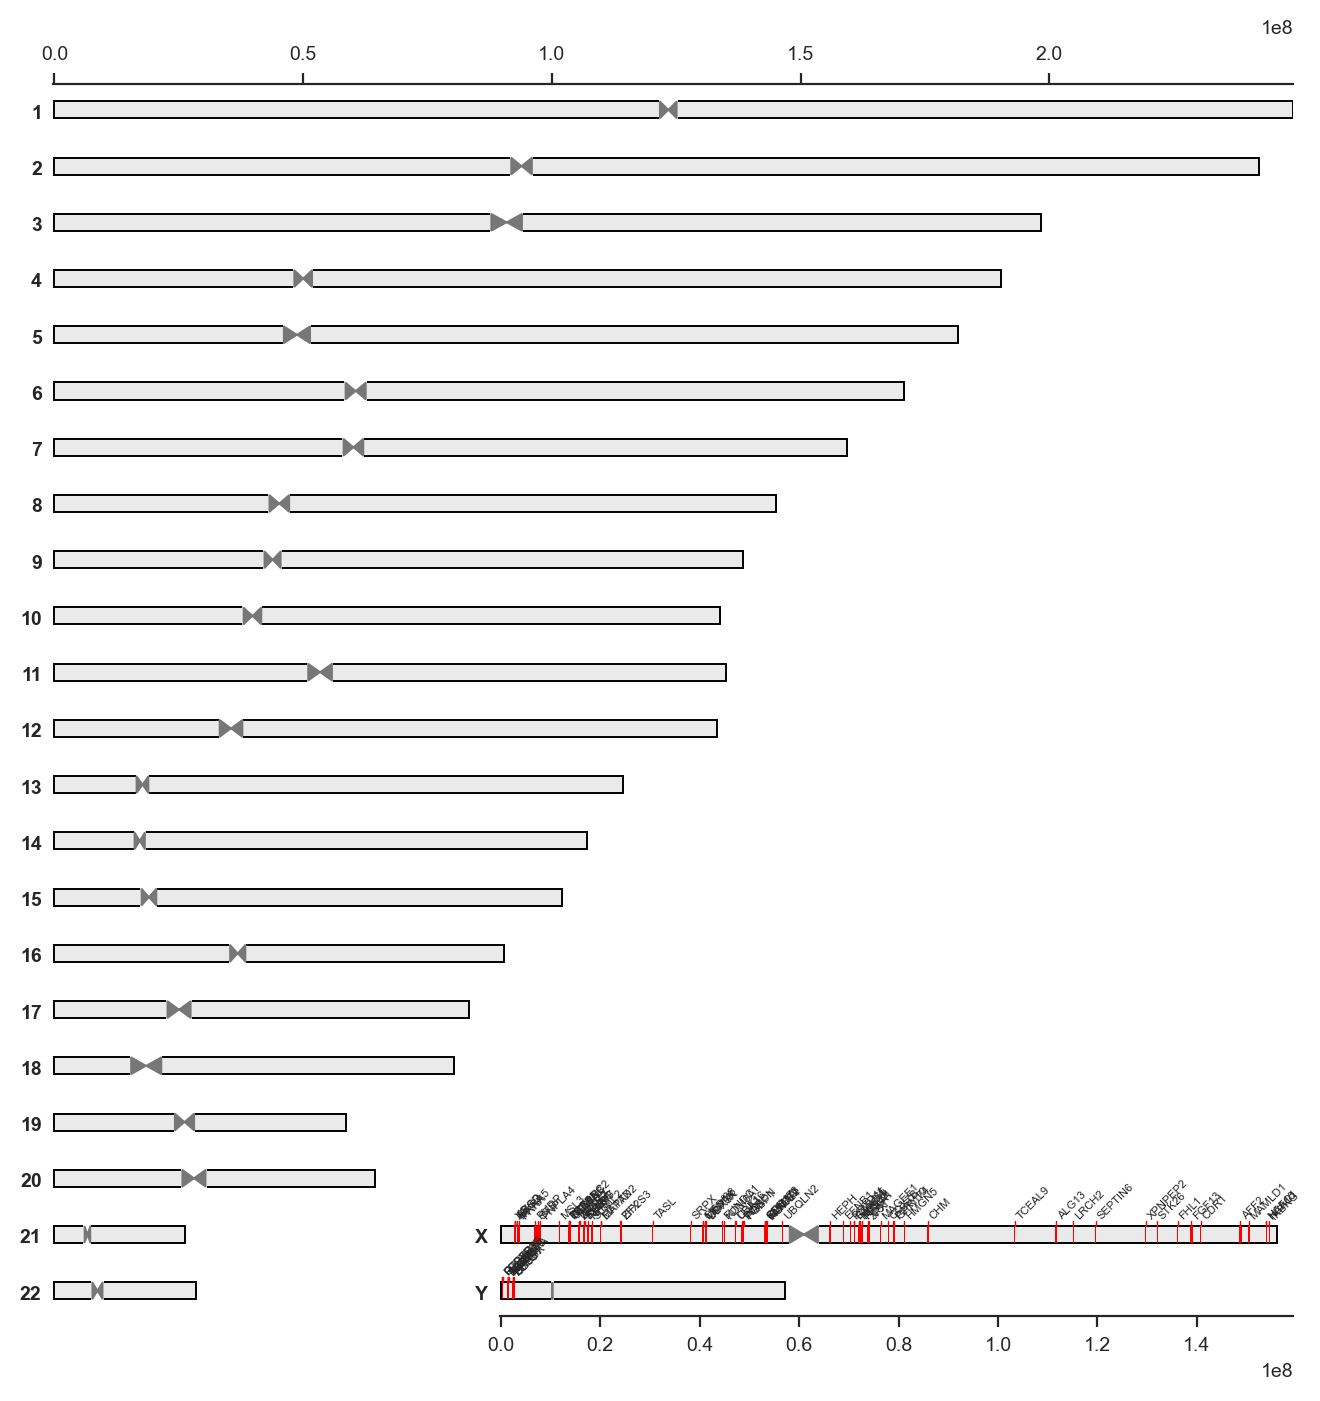

In [24]:
import importlib
import geneinfo
importlib.reload(geneinfo)

gi.chrom_ideogram(annotation, figsize=(8, 8))